In [200]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import DBSCAN
import random
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# IMPORT DATA

df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
print(df)


                   business_id                     name               address  \
0       6iYb2HFDywm3zjuRg0shjw      Oskar Blues Taproom          921 Pearl St   
1       tCbdrRPZA0oiIYSmHG3J0w  Flying Elephants at PDX   7000 NE Airport Way   
2       bvN78flM8NLprQ1a1y5dRg           The Reclaimory    4720 Hawthorne Ave   
3       oaepsyvc0J17qwi8cfrOWg              Great Clips    2566 Enterprise Rd   
4       PE9uqAjdw0E4-8mjGl3wVA        Crossfit Terminus   1046 Memorial Dr SE   
...                        ...                      ...                   ...   
160580  D2mHoIDXx9N8mS1pGoKV9Q       Eleven Oaks Realty                         
160581  bQX-kwVTyZgcdZGEPzce6Q             Webb's Honey    21777 State Rd 520   
160582  wvFZ06nmPmQ2-IVoPqVYLA    Painting with a Twist  2164 S Chickasaw Trl   
160583  GB75wPibj3IjNauaoCxyGA              Havana Cafe        910 NW 14th St   
160584  ngmLL5Y5OT-bYHKU0kKrYA              Zora Grille   1370 E Altamonte Dr   

                     city s

In [3]:
# CLEAN DATA

n = 10
print(df['state'].value_counts()[:n].index.tolist())


df_filtered = df[(df['state']=='MA')]
df_cluster = df_filtered.filter(items=['business_id','latitude','longitude','categories', 'review_count', 'stars'])
df_filtered = df_filtered.filter(items=['business_id','name','address','city','state','stars','review_count','is_open','attributes','categories'])

print(df_filtered)
print(df_filtered.shape[0])




['MA', 'OR', 'TX', 'FL', 'GA', 'BC', 'OH', 'CO', 'WA', 'CA']
                   business_id                                 name  \
11      hCABMnKtwo4Y9alQDxh2kw         Star Kreations Salon and Spa   
12      HPA_qyMEddpAEtFof02ixg                  Mr G's Pizza & Subs   
18      6fT0lYr_UgWSCZs_w1PBTQ                        Salter School   
26      hcRxdDg7DYryCxCoI8ySQA                    Longwood Galleria   
29      jGennaZUr2MsJyRhijNBfA                      Legal Sea Foods   
...                        ...                                  ...   
160556  87f7kR7nTz8WHnmtLM_S6w                                 O Ya   
160563  yQL8SrSETbbCI1U5esVJQw                  Ciao! Pizza & Pasta   
160568  hX-wc8LoHWSWjBwZ84ANcg          Chestnut Green Dental Group   
160569  _-nynGfhsMVVWWbAZ6YhTw                        The Jury Room   
160579  d6iEdtgLKelWKtb-2UmE2A  Master Finish Mobile Auto Detailing   

                       address     city state  stars  review_count  is_open  \
11     

## Cluster based on location

In [4]:
df_cluster

business_id   latitude  longitude  \
11      hCABMnKtwo4Y9alQDxh2kw  42.534248 -70.990948   
12      HPA_qyMEddpAEtFof02ixg  42.541155 -70.973438   
18      6fT0lYr_UgWSCZs_w1PBTQ  42.427889 -71.073475   
26      hcRxdDg7DYryCxCoI8ySQA  42.338544 -71.106842   
29      jGennaZUr2MsJyRhijNBfA  42.363442 -71.025781   
...                        ...        ...        ...   
160556  87f7kR7nTz8WHnmtLM_S6w  42.351408 -71.056867   
160563  yQL8SrSETbbCI1U5esVJQw  42.389221 -71.040882   
160568  hX-wc8LoHWSWjBwZ84ANcg  42.550054 -70.944788   
160569  _-nynGfhsMVVWWbAZ6YhTw  42.249118 -71.001071   
160579  d6iEdtgLKelWKtb-2UmE2A  42.282399 -71.225169   

                                               categories  review_count  stars  
11      Wigs, Hair Extensions, Hair Salons, Blow Dry/O...             8    4.0  
12                               Food, Pizza, Restaurants            39    4.0  
18      Specialty Schools, Massage Schools, Middle Sch...             5    2.0  
26                Restaurants, Shopping, Shopping Centers            24    2.5  
29      Sandwiches, Food, Restaurants, Breakfast & Bru...           856    3.5  
...                                                   ...           ...    ...  
160556                  Japanese, Sushi Bars, Restaurants           737    4.5  
160563                        Restaurants, Pizza, Italian           733    5.0  
160568      Health & Medical, Dentists, General Dentistry             6    3.0  
160569             Restaurants, American (New), Nightlife            30    3.0  
160579                         Automotive, Auto Detailing            11    1.0  

[36012 rows x 6 columns]

In [5]:
df_location = df_cluster.filter(items= ['latitude','longitude'])
df_location

latitude  longitude
11      42.534248 -70.990948
12      42.541155 -70.973438
18      42.427889 -71.073475
26      42.338544 -71.106842
29      42.363442 -71.025781
...           ...        ...
160556  42.351408 -71.056867
160563  42.389221 -71.040882
160568  42.550054 -70.944788
160569  42.249118 -71.001071
160579  42.282399 -71.225169

[36012 rows x 2 columns]

In [6]:
db = DBSCAN(eps=0.00001, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(df_location))

In [7]:
labels = db.labels_

In [8]:
labels

array([ 0,  1,  2, ..., -1, 27, -1])

In [9]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

In [10]:
-1 in labels

True

In [11]:
df_location.iloc(0)[2]['latitude']

42.427889

In [12]:
len(colors)

2131

In [13]:
labels[1]
random.shuffle(colors)

Plotting for location clusters

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_31144/4157913855.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')


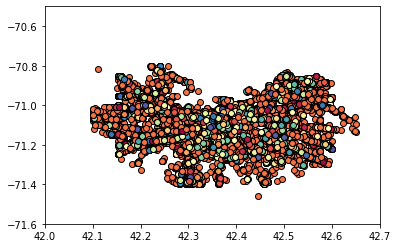

In [14]:
plt.xlim(42,42.7)
plt.ylim(-71.6,-70.5)
for i in range(0,len(labels)):
    if(labels[i] == -1):
       c = [0,0,0,1]
    c = colors[labels[i]]
    x = df_location.iloc(0)[i]['latitude']
    y = df_location.iloc(0)[i]['longitude']
    plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')

Generate list of dataframe, each containing a cluster

In [15]:
cluster_list = [None] * (len(set(labels))-1)
for i in range(0,len(labels)):
    index = labels[i]
    if index != -1:
        if cluster_list[index] == None:
            cluster_list[index] = []
            cluster_list[index].append(df_cluster.iloc(0)[i])
        else:
            cluster_list[index].append(df_cluster.iloc(0)[i])

In [16]:
for i in range(0, len(cluster_list)):
    df_new = pd.DataFrame(cluster_list[i])
    cluster_list[i] = df_new

In [17]:
t = np.array(cluster_list[0]['categories']).tolist()

In [18]:
for i in range(0,len(t)):
    text = t[i]
    t[i] = [x.strip() for x in text.split(',')]


In [19]:
unique_categories = list(set(i for j in t for i in j))
df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)

In [20]:
for i in range(0,len(t)):
    for each in t[i]:
        df_test.loc[i,each] = each
df_test.loc[0,'Wigs']
df_test.isnull().values.any()
df_test
df_test.shape

(3, 17)

In [21]:
while(df_test.isnull().values.any()==True):
    df_test.fillna(str(random.random() * 10000),inplace=True,limit=1)

## Clustering for each location cluster

The result is expected to be a list, with each element as a list of clusters. 

In [24]:
res = []
for i in range(0,len(cluster_list)):
    print("%d run:" %(i))
    t = np.array(cluster_list[i]['categories']).tolist()
    for j in range(0,len(t)):
        text = t[j]
        if(text == None):
            text = 'None'
        t[j] = [x.strip() for x in text.split(',')]
    unique_categories = list(set(k for j in t for k in j))
    df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)
    for j in range(0,len(t)):
        for each in t[j]:
            df_test.loc[j,each] = 1/len(t[j])
        df_test.fillna(0,inplace=True)
    km = KMeans(n_clusters=int(min(df_test.shape[0]/4+1,50)),verbose=1).fit(df_test)
    clusters = km.labels_
    l = [None] * len(set(clusters))
    for j in range(0,len(clusters)):
        index = clusters[j]
        if index != -1:
            if l[index] == None:
                l[index] = []
                l[index].append(cluster_list[i].iloc(0)[j])
            else:
                l[index].append(cluster_list[i].iloc(0)[j])
    res.append(l)

0 run:
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.4126984126984126.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, ine

Initialization complete
Iteration 0, inertia 10.896349206349207
Iteration 1, inertia 7.580484406006052
Iteration 2, inertia 7.4468264676240885
Iteration 3, inertia 7.379707957827005
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11.100529100529101
Iteration 1, inertia 7.224784985076651
Iteration 2, inertia 7.089847688576855
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.565873015873017
Iteration 1, inertia 7.088444015640443
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 11.3644708994709
Iteration 1, inertia 7.4136605260805615
Iteration 2, inertia 7.375416476535744
Iteration 3, inertia 7.352580982392957
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11.00503117913832
Iteration 1, inertia 7.0167227005385495
Iteration 2, inertia 6.979349600951492
Converged at iteration 2: strict convergence.
Initialization comple

9 run:
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.9166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.8333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.8333333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.8333333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.8333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8333333333333334
Converged at iterat

Initialization complete
Iteration 0, inertia 707.2691810568269
Iteration 1, inertia 498.12232694895334
Iteration 2, inertia 475.4429802329794
Iteration 3, inertia 469.2675293846169
Iteration 4, inertia 467.4263158999792
Iteration 5, inertia 466.68025029778926
Iteration 6, inertia 466.08463221207865
Iteration 7, inertia 464.65800614245876
Iteration 8, inertia 463.36070520569996
Iteration 9, inertia 463.12593374727544
Iteration 10, inertia 463.01313771695334
Iteration 11, inertia 462.91115854233897
Iteration 12, inertia 462.8074829359236
Iteration 13, inertia 462.2589503485956
Iteration 14, inertia 461.886979964039
Iteration 15, inertia 461.5952226141158
Iteration 16, inertia 461.2302257611602
Iteration 17, inertia 461.04011523938163
Iteration 18, inertia 460.90572484882534
Iteration 19, inertia 460.68795055327934
Iteration 20, inertia 460.5606184632785
Iteration 21, inertia 460.54019902335483
Iteration 22, inertia 460.52428115889177
Iteration 23, inertia 460.5177464912933
Iteration 24, 

16 run:
Initialization complete
Iteration 0, inertia 4.291587301587302
Iteration 1, inertia 2.6046567460317465
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.784126984126984
Iteration 1, inertia 2.7867989417989416
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.240158730158731
Iteration 1, inertia 2.7587758537758535
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.249603174603174
Iteration 1, inertia 2.9052777777777776
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.688253968253969
Iteration 1, inertia 2.9451917989417993
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.452301587301587
Iteration 1, inertia 2.704772486772487
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.023492063492064
Iteration 1, inertia 2.6586676286676

Initialization complete
Iteration 0, inertia 6.626181457431457
Iteration 1, inertia 3.9767095272452417
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.6658639971139975
Iteration 1, inertia 4.024852392977393
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.553562409812409
Iteration 1, inertia 4.32969954648526
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.69687950937951
Iteration 1, inertia 4.446290885040884
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.860367965367966
Iteration 1, inertia 4.045359447651114
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.081700937950938
Iteration 1, inertia 4.040463791216342
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.495878427128427
Iteration 1, inertia 4.284078132515631
Iteration 

25 run:
Initialization complete
Iteration 0, inertia 0.8333333333333335
Iteration 1, inertia 0.41666666666666674
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333335
Iteration 1, inertia 0.41666666666666674
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333335
Iteration 1, inertia 0.41666666666666674
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333335
Iteration 1, inertia 0.41666666666666674
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333335
Iteration 1, inertia 0.4

Initialization complete
Iteration 0, inertia 3.4876984126984127
Iteration 1, inertia 1.9109410430839007
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7867063492063493
Iteration 1, inertia 1.9044642857142855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3571428571428568
Iteration 1, inertia 1.9746031746031745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.378968253968254
Iteration 1, inertia 2.1306998556998558
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4484126984126986
Iteration 1, inertia 2.1805735930735928
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.501984126984127
Iteration 1, inertia 2.11194885361552
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.490079365079365
Iteration 1, inertia 1.9839947089947088
C

Iteration 1, inertia 2.0913508260447036
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9702380952380953
Iteration 1, inertia 2.16468253968254
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.829081632653061
Iteration 1, inertia 2.0913508260447036
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.995748299319728
Iteration 1, inertia 2.174684159378037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.029761904761905
Iteration 1, inertia 2.2014455782312927
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.847789115646258
Iteration 1, inertia 2.184141156462585
Converged at iteration 1: strict convergence.
37 run:
Initialization complete
Iteration 0, inertia 19.86361111111111
Iteration 1, inertia 13.331051007373684
Iteration 2, inertia 12.899225664863366
Iteration 3, inertia 

Initialization complete
Iteration 0, inertia 1.3845238095238095
Iteration 1, inertia 0.7020833333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3845238095238095
Iteration 1, inertia 0.8635714285714287
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3517857142857144
Iteration 1, inertia 0.8040178571428573
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4172619047619048
Iteration 1, inertia 0.6451190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3845238095238095
Iteration 1, inertia 0.7020833333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3517857142857144
Iteration 1, inertia 0.8040178571428573
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1970238095238095
Iteration 1, inertia 0.6451190476190

Iteration 0, inertia 3.473333333333334
Iteration 1, inertia 1.9080423280423282
Converged at iteration 1: strict convergence.
48 run:
Initialization complete
Iteration 0, inertia 2.1333333333333337
Iteration 1, inertia 1.1600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0333333333333337
Iteration 1, inertia 1.1600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1333333333333337
Iteration 1, inertia 1.1600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1333333333333337
Iteration 1, inertia 1.1600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2
Iteration 1, inertia 1.1600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1333333333333337
Iteration 1, inertia 1.1600000000000001
Converged at iteration 1: st

Initialization complete
Iteration 0, inertia 2.3142857142857145
Iteration 1, inertia 1.2665343915343914
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3650793650793656
Iteration 1, inertia 1.2996031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.353968253968254
Iteration 1, inertia 1.2659722222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2730158730158734
Iteration 1, inertia 1.2555555555555558
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.361904761904762
Iteration 1, inertia 1.3146031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.373015873015873
Iteration 1, inertia 1.3146031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3761904761904766
Iteration 1, inertia 1.2716553287981858

Initialization complete
Iteration 0, inertia 3.283766233766234
Iteration 1, inertia 2.1442795299938155
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.329220779220779
Iteration 1, inertia 2.0230880230880226
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4290043290043286
Iteration 1, inertia 2.23034632034632
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7513708513708517
Iteration 1, inertia 2.171037758537758
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.024891774891775
Iteration 1, inertia 2.058679653679653
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.183982683982684
Iteration 1, inertia 2.017708834375501
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.179004329004329
Iteration 1, inertia 2.058679653679653
Converg

Initialization complete
Iteration 0, inertia 4.829166666666666
Iteration 1, inertia 3.3712301587301585
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.727777777777778
Iteration 1, inertia 3.4221354166666673
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.680555555555555
Iteration 1, inertia 2.7997222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.763888888888889
Iteration 1, inertia 2.6745833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.227777777777778
Iteration 1, inertia 3.0366608796296295
Iteration 2, inertia 2.9549242424242426
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.512499999999999
Iteration 1, inertia 3.154166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.683333333333334
Iter

Initialization complete
Iteration 0, inertia 13.063816137566137
Iteration 1, inertia 8.889061957505834
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13.065575396825398
Iteration 1, inertia 9.073678334556433
Iteration 2, inertia 8.984488743729814
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.159649470899472
Iteration 1, inertia 9.321104214037568
Iteration 2, inertia 9.292269413273381
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.350216364323508
Iteration 1, inertia 9.005890886513336
Iteration 2, inertia 8.97188750799465
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.180740740740742
Iteration 1, inertia 8.57952035655532
Iteration 2, inertia 8.548223722822463
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.277010582010584
Iteration 1, inertia 8.97712508086625

Initialization complete
Iteration 0, inertia 14.644761904761905
Iteration 1, inertia 9.70339947089947
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 14.427248677248677
Iteration 1, inertia 9.744070626493052
Iteration 2, inertia 9.6116121819098
Iteration 3, inertia 9.4803621819098
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14.37373015873016
Iteration 1, inertia 9.411433366402116
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 15.235582010582013
Iteration 1, inertia 10.17055720899471
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 14.6890873015873
Iteration 1, inertia 9.637701597099745
Iteration 2, inertia 9.563359788359788
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 14.046494708994707
Iteration 1, inertia 9.68400330057949
Iteration 2, inertia 9.647664871504157
Conve

Initialization complete
Iteration 0, inertia 1.0750000000000002
Iteration 1, inertia 0.6020833333333333
Converged at iteration 1: strict convergence.
84 run:
Initialization complete
Iteration 0, inertia 9.882738095238095
Iteration 1, inertia 6.444004120236759
Iteration 2, inertia 6.420055153180153
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.590241702741704
Iteration 1, inertia 6.585363452154342
Iteration 2, inertia 6.541784211159212
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.772486772486772
Iteration 1, inertia 6.828154898188232
Iteration 2, inertia 6.703387302732542
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.672967772967773
Iteration 1, inertia 6.57161469843288
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.678030303030305
Iteration 1, inertia 6.89377536049984
Iteration 2, inertia 6.6443204

Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.43750000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.43750000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4375.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.43750000000000006.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4

Iteration 0, inertia 1.0575396825396823
Iteration 1, inertia 0.6198743386243386
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.103174603174603
Iteration 1, inertia 0.6369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.337301587301587
Iteration 1, inertia 0.6643518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3849206349206349
Iteration 1, inertia 0.8424603174603175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0753968253968254
Iteration 1, inertia 0.636904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1904761904761905
Iteration 1, inertia 0.6198743386243386
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.353174603174603
Iteration 1, inertia 0.8244047619047619
Converged at iteration 1

Initialization complete
Iteration 0, inertia 17.038492063492065
Iteration 1, inertia 11.213821239606954
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 18.246944444444445
Iteration 1, inertia 11.536373482726422
Iteration 2, inertia 11.470725334578276
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.116825396825398
Iteration 1, inertia 10.975388227513227
Iteration 2, inertia 10.910045827821868
Iteration 3, inertia 10.867630291005291
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 17.127301587301588
Iteration 1, inertia 11.382378117132987
Iteration 2, inertia 11.109445274742892
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.37219576719577
Iteration 1, inertia 11.466344918488657
Iteration 2, inertia 11.403839427437642
Iteration 3, inertia 11.338353774157126
Iteration 4, inertia 11.284408541194257
Converged at iter

108 run:
Initialization complete
Iteration 0, inertia 15.048076685219542
Iteration 1, inertia 9.940312847132901
Iteration 2, inertia 9.829101977828168
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.522262591905449
Iteration 1, inertia 9.88413176168335
Iteration 2, inertia 9.611089222487536
Iteration 3, inertia 9.592068946352136
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14.375821995464854
Iteration 1, inertia 9.542672139621843
Iteration 2, inertia 9.524893813417624
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 14.96308802308802
Iteration 1, inertia 9.94374837515531
Iteration 2, inertia 9.78731492933874
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.158174603174604
Iteration 1, inertia 9.807042071973992
Iteration 2, inertia 9.760858028335301
Converged at iteration 2: strict convergence.
Initialization c

Initialization complete
Iteration 0, inertia 9.796666666666667
Iteration 1, inertia 5.860858134920635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.02
Iteration 1, inertia 6.0008760288065846
Iteration 2, inertia 5.900976851851851
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.060833333333333
Iteration 1, inertia 5.805769841269841
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.643333333333333
Iteration 1, inertia 5.8040692640692635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.723333333333334
Iteration 1, inertia 6.195849567099568
Iteration 2, inertia 5.981616899514628
Iteration 3, inertia 5.938884920634921
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9.965555555555557
Iteration 1, inertia 6.16244074074074
Iteration 2, inertia 5.822927177815571
Iteration 3, 

Initialization complete
Iteration 0, inertia 2.7
Iteration 1, inertia 1.7358333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7895833333333333
Iteration 1, inertia 1.9372395833333331
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.008333333333333
Iteration 1, inertia 2.001785714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3895833333333334
Iteration 1, inertia 1.5504960317460317
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5229166666666667
Iteration 1, inertia 1.6660590277777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3895833333333334
Iteration 1, inertia 1.6660590277777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7555555555555555
Iteration 1, inertia 1.4785590277777776
Converged at 

Initialization complete
Iteration 0, inertia 19.269142246642247
Iteration 1, inertia 12.47733154556077
Iteration 2, inertia 12.243463286793904
Iteration 3, inertia 12.178790121034169
Converged at iteration 3: strict convergence.
124 run:
Initialization complete
Iteration 0, inertia 4.4636054421768705
Iteration 1, inertia 2.5847250566893427
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.598412698412698
Iteration 1, inertia 3.098781179138322
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.423809523809524
Iteration 1, inertia 2.573597613648634
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.314285714285714
Iteration 1, inertia 2.4437011841773746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.542630385487529
Iteration 1, inertia 2.826211892164273
Iteration 2, inertia 2.7701958359101218
Converged at iteration 2:

Initialization complete
Iteration 0, inertia 4.273809523809525
Iteration 1, inertia 2.755952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.4523809523809526
Iteration 1, inertia 2.5595238095238093
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.378571428571429
Iteration 1, inertia 2.5771428571428565
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.5357142857142865
Iteration 1, inertia 2.6845238095238093
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.4261904761904765
Iteration 1, inertia 2.584722222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.95
Iteration 1, inertia 2.6232426303854877
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.835714285714286
Iteration 1, inertia 2.69375
Converged at iteration 1: 

Initialization complete
Iteration 0, inertia 7.089342403628119
Iteration 1, inertia 4.770085481561045
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.486011904761904
Iteration 1, inertia 4.483256999559083
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.98045634920635
Iteration 1, inertia 4.233667328042328
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.784623015873016
Iteration 1, inertia 4.791744708994709
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.942083333333333
Iteration 1, inertia 4.440105799606715
Iteration 2, inertia 4.219697227375799
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.601587301587302
Iteration 1, inertia 4.03977564102564
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.973767006802721
Iteration 1,

Initialization complete
Iteration 0, inertia 2.1194444444444445
Iteration 1, inertia 1.1897222222222221
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.072777777777778
Iteration 1, inertia 1.216388888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8444444444444446
Iteration 1, inertia 1.0310185185185183
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.128333333333334
Iteration 1, inertia 1.272611111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.241666666666667
Iteration 1, inertia 1.3297222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9533333333333336
Iteration 1, inertia 1.0459722222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9416666666666669
Iteration 1, inertia 1.0686111111111112
C

Initialization complete
Iteration 0, inertia 0.7954545454545453.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0454545454545454.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict convergence.
153 run:
Initialization complete
Iteration 0, inertia 10.029920634920634
Iteration 1, inertia 6.392557014414157
Iteration 2, inertia 6.293527514711581
Iteration 3, inertia 6.242506096967407
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9.55075036075036
Iteration 1, inertia 5.968227372935707
Iteration 2, inertia 5.90050955988456
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.875595409881125
Iteration 1, inertia 5.78411924421845
Iteration 2, inertia 5.6925497433405

Initialization complete
Iteration 0, inertia 3.7500000000000004
Iteration 1, inertia 2.130555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.666666666666667
Iteration 1, inertia 2.0375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.85
Iteration 1, inertia 2.0933333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8000000000000003
Iteration 1, inertia 2.1183333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.416666666666667
Iteration 1, inertia 1.9177777777777782
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.45
Iteration 1, inertia 2.0375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5
Iteration 1, inertia 2.0775
Converged at iteration 1: strict convergence.
Initialization complete
Iteratio

Initialization complete
Iteration 0, inertia 5.008895073180787
Iteration 1, inertia 2.870749587713873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.28663677592249
Iteration 1, inertia 2.7482958840101697
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.772747887033601
Iteration 1, inertia 2.8408884766027622
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.0805916305916305
Iteration 1, inertia 3.153587826315099
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.17552566481138
Iteration 1, inertia 2.8887245470578806
Iteration 2, inertia 2.8088803854875284
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.967192331478046
Iteration 1, inertia 2.623424036281179
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.455627705627705
Iterati

Initialization complete
Iteration 0, inertia 16.707824166574166
Iteration 1, inertia 11.048591741705303
Iteration 2, inertia 10.760118925551962
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.620020759663618
Iteration 1, inertia 11.304778087952188
Iteration 2, inertia 10.971604140843723
Iteration 3, inertia 10.936493827641913
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 16.925921386814245
Iteration 1, inertia 11.148074813717484
Iteration 2, inertia 10.91798056294088
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.578620916120915
Iteration 1, inertia 10.787699851675738
Iteration 2, inertia 10.682115366249082
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.96324161949162
Iteration 1, inertia 10.723279865023615
Iteration 2, inertia 10.649916347650539
Converged at iteration 2: strict convergence.
Initializati

178 run:
Initialization complete
Iteration 0, inertia 6.376269841269842
Iteration 1, inertia 3.7471119929453267
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.017460317460318
Iteration 1, inertia 3.917891952102478
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.807301587301588
Iteration 1, inertia 4.0553438649533895
Iteration 2, inertia 4.027303004535147
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.959920634920636
Iteration 1, inertia 4.03721626984127
Iteration 2, inertia 3.9668290043290044
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.212460317460318
Iteration 1, inertia 3.969405234315949
Iteration 2, inertia 3.864919123204838
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.7509523809523815
Iteration 1, inertia 4.121213641561949
Iteration 2, inertia 4.088346

Iteration 1, inertia 10.837820602089488
Iteration 2, inertia 10.683201185608922
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.189311138596857
Iteration 1, inertia 11.148531306700354
Iteration 2, inertia 10.870502161154825
Iteration 3, inertia 10.84631906933855
Converged at iteration 3: strict convergence.
184 run:
Initialization complete
Iteration 0, inertia 2.291666666666667
Iteration 1, inertia 1.1750000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 1.1166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0833333333333335
Iteration 1, inertia 1.3166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.625
Iteration 1, inertia 1.2083333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.291

Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.

Iteration 1, inertia 1.360407218442933
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1119047619047624
Iteration 1, inertia 1.3604072184429326
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1796296296296296
Iteration 1, inertia 1.414331605658136
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6949735449735455
Iteration 1, inertia 1.414331605658136
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1796296296296296
Iteration 1, inertia 1.2570641219450744
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.639417989417989
Iteration 1, inertia 1.334305150631681
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7462207105064245
Iteration 1, inertia 1.6372448979591834
Converged at iteration 1: strict convergence.
Initialization comp

Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0714285714285714
Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0714285714285714
Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8877551020408163
Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1785714285714286
Iteration 1, inertia 0.6369047619047619
Converged at iteration 1: strict convergence.
202 run:
Initialization complete
Iteration 0, inertia 0.5555555555555556
Iteration 1, inertia 0.32407407407407407
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4166666666666667
Iteration 1, inertia 0.25
Converged at iteration 1: strict convergence.
Initialization complet

Initialization complete
Iteration 0, inertia 2.371031746031746
Iteration 1, inertia 1.437830687830688
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6507936507936503
Iteration 1, inertia 1.6767423115079367
Iteration 2, inertia 1.5679327286470142
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.4404761904761907
Iteration 1, inertia 1.5859788359788356
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1626984126984126
Iteration 1, inertia 1.3857473544973546
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5634920634920633
Iteration 1, inertia 1.718005952380952
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3988095238095237
Iteration 1, inertia 1.3857473544973546
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3988095238095237

Initialization complete
Iteration 0, inertia 7.877264693756291
Iteration 1, inertia 5.06510692890563
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.843285799168152
Iteration 1, inertia 5.319039541895729
Iteration 2, inertia 5.208400841971314
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.277597402597403
Iteration 1, inertia 5.632434504585865
Iteration 2, inertia 5.4489207551707555
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.055050505050504
Iteration 1, inertia 5.629838992100654
Iteration 2, inertia 5.332864754293325
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.401895000424414
Iteration 1, inertia 4.878217844376809
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.519967532467533
Iteration 1, inertia 5.515181819697576
Iteration 2, inertia 5.345795493655748
It

Initialization complete
Iteration 0, inertia 2.908333333333333
Iteration 1, inertia 1.683049886621315
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.771428571428572
Iteration 1, inertia 1.5473733938019654
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2595238095238095
Iteration 1, inertia 1.534404761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.315079365079365
Iteration 1, inertia 1.506498015873016
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.069047619047619
Iteration 1, inertia 1.3253968253968251
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.626190476190476
Iteration 1, inertia 1.5257936507936511
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8130952380952383
Iteration 1, inertia 1.5843253968253967
Conv

Initialization complete
Iteration 0, inertia 23.165048364334076
Iteration 1, inertia 14.815490618868626
Iteration 2, inertia 14.616258138475889
Iteration 3, inertia 14.51339317931433
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 22.542975133332277
Iteration 1, inertia 15.090023968437242
Iteration 2, inertia 14.9399413843732
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 22.45823264918503
Iteration 1, inertia 15.062155265999323
Iteration 2, inertia 14.879748990534605
Iteration 3, inertia 14.843556967056946
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 23.50673546911642
Iteration 1, inertia 15.568992226973721
Iteration 2, inertia 15.340873107701503
Iteration 3, inertia 15.285221530278315
Iteration 4, inertia 15.256819914658086
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 23.585314513528797
Iteration 1, inertia 

Initialization complete
Iteration 0, inertia 1.7851851851851854
Iteration 1, inertia 1.1141975308641974
Converged at iteration 1: strict convergence.
231 run:
Initialization complete
Iteration 0, inertia 4.712755102040816
Iteration 1, inertia 2.796616354875283
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.428287981859411
Iteration 1, inertia 2.8095804988662136
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.712755102040816
Iteration 1, inertia 2.8297146636432355
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.691326530612245
Iteration 1, inertia 2.830764597505669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.4640022675736954
Iteration 1, inertia 2.6735232426303854
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.466468253968253
Iteration 1, inertia 2.76881141345

Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia

Iteration 1, inertia 0.4095238095238095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.680952380952381
Iteration 1, inertia 0.3404761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.35555555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.35555555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.680952380952381
Iteration 1, inertia 0.3404761904761905
Converged at iteration 1: strict convergence.
244 run:
Initialization complete
Iteration 0, inertia 4.722222222222222
Iteration 1, inertia 2.7634920634920634
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.366666666666667
Iteration 1, inertia 2.73989898989899
Converged at iteration 1: strict convergence.
Initializ

Initialization complete
Iteration 0, inertia 5.673129251700681
Iteration 1, inertia 3.498513085789871
Iteration 2, inertia 3.3655689548546697
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.158843537414967
Iteration 1, inertia 3.2124678760393044
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.448299319727892
Iteration 1, inertia 3.563692022263451
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.527551020408165
Iteration 1, inertia 3.6005980725623576
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.7017006802721095
Iteration 1, inertia 3.2835343228200378
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.541700680272109
Iteration 1, inertia 3.1641885325558796
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.015986394557824
Iter

Initialization complete
Iteration 0, inertia 3.3277777777777775
Iteration 1, inertia 1.8486111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.683333333333333
Iteration 1, inertia 1.8402777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3499999999999996
Iteration 1, inertia 1.9375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.266666666666666
Iteration 1, inertia 1.778888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.716666666666667
Iteration 1, inertia 1.9322222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3611111111111107
Iteration 1, inertia 1.825925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.127777777777778
Iteration 1, inertia 1.8972222222222224
Converged at i

Initialization complete
Iteration 0, inertia 2.033333333333333
Iteration 1, inertia 1.0847222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333333
Iteration 1, inertia 1.0847222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3666666666666667
Iteration 1, inertia 1.0847222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 1.0847222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.366666666666667
Iteration 1, inertia 1.0847222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2
Iteration 1, inertia 1.0847222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.05
Iteration 1, inertia 1.0847222222222224
Converged at iteration 1: st

Iteration 0, inertia 1.2857142857142858.
Iteration 1, inertia 0.761904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2857142857142858.
Iteration 1, inertia 0.761904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2857142857142858.
Iteration 1, inertia 0.761904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2857142857142858.
Iteration 1, inertia 0.761904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6428571428571428.
Iteration 1, inertia 0.761904761904762.
Converged at iteration 1: strict convergence.
270 run:
Initialization complete
Iteration 0, inertia 12.471210317460317
Iteration 1, inertia 8.405394734151274
Iteration 2, inertia 8.290617699099844
Iteration 3, inertia 8.229109762591907
Converged at iteration 3: strict convergence.
Initialization complete
Iteration

Initialization complete
Iteration 0, inertia 13.18410052910053
Iteration 1, inertia 8.332990729808909
Iteration 2, inertia 8.298494708994708
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.737936507936508
Iteration 1, inertia 8.198395328950884
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13.180000000000003
Iteration 1, inertia 8.411593475470399
Iteration 2, inertia 8.373420634920635
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.97325396825397
Iteration 1, inertia 7.976936507936507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13.03420634920635
Iteration 1, inertia 8.715892551892551
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 12.555132275132276
Iteration 1, inertia 8.264821856734738
Iteration 2, inertia 8.152215247715247
Converged at iteration 2: strict conve

Initialization complete
Iteration 0, inertia 4.054292929292929
Iteration 1, inertia 2.495193602693603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7640572390572387
Iteration 1, inertia 2.4997390572390574
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4861111111111107
Iteration 1, inertia 2.489259259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.870959595959596
Iteration 1, inertia 2.406257014590348
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4936868686868685
Iteration 1, inertia 2.3457575757575757
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6148989898989896
Iteration 1, inertia 2.3470454545454547
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4179292929292924
Iteration 1, inertia 2.4229262320171414
C

Initialization complete
Iteration 0, inertia 21.88156596890363
Iteration 1, inertia 15.21322277101711
Iteration 2, inertia 15.01566518761621
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 21.64275372775373
Iteration 1, inertia 14.226263351252749
Iteration 2, inertia 14.1890497072005
Iteration 3, inertia 14.13687941086556
Iteration 4, inertia 14.096702353276278
Iteration 5, inertia 14.070419079031323
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 22.029129045557617
Iteration 1, inertia 14.533673606868089
Iteration 2, inertia 14.359121163436953
Iteration 3, inertia 14.299423506596439
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 20.83750563770044
Iteration 1, inertia 14.732207474967158
Iteration 2, inertia 14.366962217229545
Iteration 3, inertia 14.246380483280857
Iteration 4, inertia 14.229412331181056
Iteration 5, inertia 14.210544892727253
Converged at i

Initialization complete
Iteration 0, inertia 4.371428571428571
Iteration 1, inertia 2.279883381924198
Iteration 2, inertia 2.1536078717201166
Converged at iteration 2: strict convergence.
291 run:
Initialization complete
Iteration 0, inertia 1.611111111111111
Iteration 1, inertia 0.8009259259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4444444444444442
Iteration 1, inertia 0.7361111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.7361111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4444444444444442
Iteration 1, inertia 0.7361111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.7361111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4444444

296 run:
Initialization complete
Iteration 0, inertia 5.729637188208618
Iteration 1, inertia 3.8917189386577147
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.112970521541951
Iteration 1, inertia 3.9885143613000755
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.836825396825398
Iteration 1, inertia 3.803139880952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.049682539682541
Iteration 1, inertia 4.043587708587708
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.196984126984127
Iteration 1, inertia 3.930142657795719
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.585873015873016
Iteration 1, inertia 3.592915576487005
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.696145124716554
Iteration 1, inertia 3.560653061224489

Initialization complete
Iteration 0, inertia 2.683333333333333
Iteration 1, inertia 1.5157407407407408
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.086111111111111
Iteration 1, inertia 1.5091269841269839
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.744444444444445
Iteration 1, inertia 1.6677083333333331
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6611111111111114
Iteration 1, inertia 1.509126984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6833333333333336
Iteration 1, inertia 1.525396825396825
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7055555555555557
Iteration 1, inertia 1.4624074074074072
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.661111111111111
Iteration 1, inertia 1.5947916666666664
Co

309 run:
Initialization complete
Iteration 0, inertia 2.257575757575758
Iteration 1, inertia 0.975189393939394
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0492424242424243
Iteration 1, inertia 1.131060606060606
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6053030303030305
Iteration 1, inertia 0.8360606060606061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7742424242424242
Iteration 1, inertia 1.0840909090909092
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5325757575757577
Iteration 1, inertia 0.8360606060606062
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.257575757575758
Iteration 1, inertia 0.8360606060606061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5325757575757577
Iteration 1, inertia 0.83606060

Initialization complete
Iteration 0, inertia 4.230555555555555
Iteration 1, inertia 2.6936213991769544
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.091666666666667
Iteration 1, inertia 2.409259259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7870370370370368
Iteration 1, inertia 2.621581196581196
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.679629629629629
Iteration 1, inertia 2.2938888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7120370370370366
Iteration 1, inertia 2.3942901234567895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.804629629629629
Iteration 1, inertia 2.4498971193415637
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5731481481481477
Iteration 1, inertia 2.516335978835979
Con

Initialization complete
Iteration 0, inertia 2.955952380952381
Iteration 1, inertia 1.736772486772487
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.689285714285714
Iteration 1, inertia 1.501785714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4416666666666664
Iteration 1, inertia 1.6647321428571427
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.189285714285714
Iteration 1, inertia 1.500892857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8154761904761902
Iteration 1, inertia 1.5289682539682539
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.316666666666667
Iteration 1, inertia 1.67989417989418
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9107142857142856
Iteration 1, inertia 1.5484126984126985
Conve

Iteration 0, inertia 2.117857142857143
Iteration 1, inertia 1.0898809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.567857142857143
Iteration 1, inertia 1.0898809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.917857142857143
Iteration 1, inertia 0.9232142857142858
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9392857142857143
Iteration 1, inertia 1.0898809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9892857142857145
Iteration 1, inertia 1.131547619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9178571428571431
Iteration 1, inertia 0.9232142857142858
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6892857142857143
Iteration 1, inertia 0.9232142857142859
Converged at iteration 1

Initialization complete
Iteration 0, inertia 6.136507936507937
Iteration 1, inertia 3.670436507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.3730158730158735
Iteration 1, inertia 3.881729497354497
Iteration 2, inertia 3.8144465488215484
Iteration 3, inertia 3.7433862433862437
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 6.529365079365079
Iteration 1, inertia 4.217584325396825
Iteration 2, inertia 4.162500881834215
Iteration 3, inertia 4.076171579743008
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 6.475
Iteration 1, inertia 3.747201607915893
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.128571428571429
Iteration 1, inertia 3.871164021164021
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.484126984126984
Iteration 1, inertia 3.88994708994709
Converged at

Initialization complete
Iteration 0, inertia 6.633995726495726
Iteration 1, inertia 3.8297754149143035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.938034188034188
Iteration 1, inertia 3.977005327344613
Iteration 2, inertia 3.9310576923076925
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.838532763532763
Iteration 1, inertia 3.8428261514719857
Iteration 2, inertia 3.761576151471985
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.956125356125357
Iteration 1, inertia 3.81879644931891
Iteration 2, inertia 3.7673463912630583
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.247507122507123
Iteration 1, inertia 4.132212309575946
Iteration 2, inertia 3.9507094017094015
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.503846153846154
Iteration 1, inertia 4.01478344186677

Initialization complete
Iteration 0, inertia 3.9611111111111112
Iteration 1, inertia 2.174809027777777
Iteration 2, inertia 2.147010582010582
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.356481481481482
Iteration 1, inertia 1.9846891534391533
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5153703703703707
Iteration 1, inertia 2.0597633744855965
Iteration 2, inertia 1.9527448559670777
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.269814814814815
Iteration 1, inertia 2.0058148148148147
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.578888888888889
Iteration 1, inertia 2.540406349206349
Iteration 2, inertia 2.2431226379440665
Iteration 3, inertia 2.1237433862433863
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 3.169444444444445
Iteration 1, inertia 2.1401587301

Initialization complete
Iteration 0, inertia 1.771212121212121
Iteration 1, inertia 1.2979640151515153
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9954545454545456
Iteration 1, inertia 1.430513468013468
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7712121212121215
Iteration 1, inertia 1.2979640151515153
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.398106060606061
Iteration 1, inertia 1.2562689393939395
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7712121212121215
Iteration 1, inertia 1.2979640151515153
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9454545454545453
Iteration 1, inertia 1.3860690235690236
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.356439393939394
Iteration 1, inertia 1.3852746212121212


Initialization complete
Iteration 0, inertia 11.001794951080665
Iteration 1, inertia 6.672186814367841
Iteration 2, inertia 6.516779575069258
Iteration 3, inertia 6.386433068370412
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10.482441024583881
Iteration 1, inertia 6.796359107806613
Iteration 2, inertia 6.768589302200698
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.839956313527743
Iteration 1, inertia 7.3334018206886125
Iteration 2, inertia 7.240497714480862
Iteration 3, inertia 7.150657164426246
Iteration 4, inertia 7.101104634051957
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10.433443567014995
Iteration 1, inertia 7.032220481954113
Iteration 2, inertia 6.98686166313845
Iteration 3, inertia 6.962026527705101
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10.328796917368345
Iteration 1, inertia 6.85968

Initialization complete
Iteration 0, inertia 10.266876417233561
Iteration 1, inertia 6.621307397959184
Iteration 2, inertia 6.542272449654465
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.87212962962963
Iteration 1, inertia 6.538660199239686
Iteration 2, inertia 6.515319865319865
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.456256613756615
Iteration 1, inertia 7.069038875862639
Iteration 2, inertia 6.977074815616483
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.92170634920635
Iteration 1, inertia 7.0273260617004
Iteration 2, inertia 6.882582880605946
Iteration 3, inertia 6.823268644494835
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10.090119047619048
Iteration 1, inertia 6.514672871000252
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.621608087679517
I

Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
372 run:
Initialization complete
Iteration 0, inertia 9.548809523809524
Iteration 1, inertia 6.257188112384871
Iteration 2, inertia 6.134747018298059
Iteration 3, inertia 6.099639336833601
Iteration 4, inertia 6.064737733056186
Iteration 5, inertia 6.028570287144005
Iteration 6, inertia 5.986459435626102
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10.489484126984127
Iteration 1, inertia 6.266955676

Initialization complete
Iteration 0, inertia 2.363492063492064
Iteration 1, inertia 1.5213109935332156
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.657671957671958
Iteration 1, inertia 1.7578042328042327
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.602116402116402
Iteration 1, inertia 1.6466931216931218
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.649206349206349
Iteration 1, inertia 1.3953850676072899
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0650793650793653
Iteration 1, inertia 1.932989417989418
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.733862433862434
Iteration 1, inertia 1.5512698412698411
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.806349206349206
Iteration 1, inertia 1.6369708994708991
Con

Initialization complete
Iteration 0, inertia 5.233333333333333
Iteration 1, inertia 3.402314814814815
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.405555555555556
Iteration 1, inertia 3.518148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.977777777777778
Iteration 1, inertia 3.317094017094017
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.933333333333334
Iteration 1, inertia 3.288444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.437777777777778
Iteration 1, inertia 3.0238047138047137
Converged at iteration 1: strict convergence.
384 run:
Initialization complete
Iteration 0, inertia 1.8055555555555558
Iteration 1, inertia 1.0777777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 1.21111111111111

Initialization complete
Iteration 0, inertia 5.558359788359788
Iteration 1, inertia 3.6697152335360954
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.511836734693878
Iteration 1, inertia 3.608371740362812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.537037037037037
Iteration 1, inertia 3.532669088066815
Iteration 2, inertia 3.4917681615856218
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.9869690098261525
Iteration 1, inertia 3.256090954900478
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.386192995716805
Iteration 1, inertia 3.454426618795667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.847339380196523
Iteration 1, inertia 3.7299722852103807
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.768148148148148
Iterat

Initialization complete
Iteration 0, inertia 6.255555555555556
Iteration 1, inertia 4.297981481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.366666666666667
Iteration 1, inertia 4.1663492063492065
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.066666666666666
Iteration 1, inertia 4.140154320987654
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.843333333333334
Iteration 1, inertia 3.967579365079365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.432222222222223
Iteration 1, inertia 3.9104814814814812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.480555555555556
Iteration 1, inertia 3.99625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.252777777777778
Iteration 1, inertia 4.003214285714286
Converged at itera

Initialization complete
Iteration 0, inertia 0.4404761904761904
Iteration 1, inertia 0.2202380952380952
Converged at iteration 1: strict convergence.
402 run:
Initialization complete
Iteration 0, inertia 3.1466666666666665
Iteration 1, inertia 1.959675925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.409761904761905
Iteration 1, inertia 2.207278911564626
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.142857142857143
Iteration 1, inertia 1.9772162698412699
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5404761904761903
Iteration 1, inertia 2.0595529761904765
Iteration 2, inertia 1.9680489417989417
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.3868452380952383
Iteration 1, inertia 2.1413154027042918
Iteration 2, inertia 2.046361607142857
Converged at iteration 2: strict convergence.
Initialization c

Initialization complete
Iteration 0, inertia 2.3536281179138325
Iteration 1, inertia 1.409731670445956
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.570294784580499
Iteration 1, inertia 1.4550156570564734
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.325850340136055
Iteration 1, inertia 1.4122197026958931
Converged at iteration 1: strict convergence.
410 run:
Initialization complete
Iteration 0, inertia 1.4
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4
Iteration 1, inertia 0.725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inerti

Iteration 0, inertia 4.447222222222223
Iteration 1, inertia 2.5487654320987656
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9305555555555554
Iteration 1, inertia 2.604976851851852
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.897222222222223
Iteration 1, inertia 3.076944444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.058333333333334
Iteration 1, inertia 2.6069444444444443
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.863888888888889
Iteration 1, inertia 2.761728395061728
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8083333333333336
Iteration 1, inertia 2.460277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.058333333333334
Iteration 1, inertia 2.6069444444444443
Converged at iteration 1: str

Initialization complete
Iteration 0, inertia 6.4
Iteration 1, inertia 3.184338888888889
Iteration 2, inertia 3.1124845679012347
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.120000000000001
Iteration 1, inertia 3.3722649572649575
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.508333333333334
Iteration 1, inertia 3.2051010101010102
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.883333333333334
Iteration 1, inertia 3.1431111111111116
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.361111111111111
Iteration 1, inertia 3.1398611111111108
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.8
Iteration 1, inertia 3.100509259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.716666666666667
Iteration 1, inertia 3.0074537037

Initialization complete
Iteration 0, inertia 0.7857142857142858
Iteration 1, inertia 0.4305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142858
Iteration 1, inertia 0.4305555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7380952380952381
Iteration 1, inertia 0.4857142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222223
Iteration 1, inertia 0.4305555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222223
Iteration 1, inertia 0.4305555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0079365079365081
Iteration 1, inertia 0.4857142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142858
Iteration 1, inertia 0.4305555555555

Iteration 1, inertia 5.036081349206349
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.809107142857143
Iteration 1, inertia 5.099401455026455
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.801904761904763
Iteration 1, inertia 5.311187770562771
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.339345238095238
Iteration 1, inertia 5.4716555555555555
Iteration 2, inertia 5.436497783358134
Iteration 3, inertia 5.3945880018674135
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 7.946428571428571
Iteration 1, inertia 5.0348781179138316
Converged at iteration 1: strict convergence.
435 run:
Initialization complete
Iteration 0, inertia 0.8888888888888886
Iteration 1, inertia 0.5162037037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1111111111111112
Iteration 1, inerti

Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.38888888888888895.

Initialization complete
Iteration 0, inertia 3.607063492063492
Iteration 1, inertia 1.9707142857142854
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.483333333333333
Iteration 1, inertia 2.099446208112875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5111111111111106
Iteration 1, inertia 2.0453174603174604
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7035714285714283
Iteration 1, inertia 2.0424735449735447
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5451587301587297
Iteration 1, inertia 2.0940119047619046
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.386111111111111
Iteration 1, inertia 1.9947559523809522
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6126190476190474
Iteration 1, inertia 1.995328798185941
C

454 run:
Initialization complete
Iteration 0, inertia 2.1561904761904764
Iteration 1, inertia 1.096137566137566
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0619047619047617
Iteration 1, inertia 1.1536054421768704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2285714285714286
Iteration 1, inertia 1.3250340136054422
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0085714285714285
Iteration 1, inertia 1.2107936507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0857142857142854
Iteration 1, inertia 1.0961375661375663
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.33968253968254
Iteration 1, inertia 1.3123356009070295
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2228571428571433
Iteration 1, inertia 1.3107936

Iteration 0, inertia 1.75
Iteration 1, inertia 0.9400000000000001
Converged at iteration 1: strict convergence.
462 run:
Initialization complete
Iteration 0, inertia 1.9642857142857144
Iteration 1, inertia 1.1357142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.157142857142857
Iteration 1, inertia 1.1357142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2642857142857142
Iteration 1, inertia 1.1285714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9642857142857144
Iteration 1, inertia 1.219047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2785714285714285
Iteration 1, inertia 1.0880952380952382
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.857142857142857
Iteration 1, inertia 1.1285714285714286
Converged at iteration 1: st

Initialization complete
Iteration 0, inertia 2.825
Iteration 1, inertia 1.529365079365079
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5166666666666666
Iteration 1, inertia 1.4055555555555552
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6194444444444445
Iteration 1, inertia 1.5263888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5166666666666666
Iteration 1, inertia 1.4055555555555552
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.841666666666667
Iteration 1, inertia 1.6131944444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3416666666666663
Iteration 1, inertia 1.4055555555555552
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.925
Iteration 1, inertia 1.5159722222222225
Converged at iteration 1

Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8571428571428571
Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7285714285714286
Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5857142857142856
Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7047619047619047
Iteration 1, inertia 0.4126984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619
Iteration 1, inertia 0.4126984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619
Iteration 1, inertia 0.4126984126984127
Converged at iteration 1: strict convergence.
476 run:
Initi

Initialization complete
Iteration 0, inertia 4.556818181818182
Iteration 1, inertia 3.2932334710743802
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.8931818181818185
Iteration 1, inertia 2.7206168831168833
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.679545454545454
Iteration 1, inertia 3.2051346801346794
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.85
Iteration 1, inertia 3.0841425619834713
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.488636363636363
Iteration 1, inertia 3.3525252525252522
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.243181818181819
Iteration 1, inertia 3.1025883838383836
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.925
Iteration 1, inertia 2.9768939393939395
Converged at iteration 1: s

Iteration 0, inertia 1.3380952380952382
Iteration 1, inertia 0.7035714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2714285714285716
Iteration 1, inertia 0.7035714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2714285714285716
Iteration 1, inertia 0.7035714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.380952380952381
Iteration 1, inertia 0.9285714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2714285714285716
Iteration 1, inertia 0.7035714285714285
Converged at iteration 1: strict convergence.
487 run:
Initialization complete
Iteration 0, inertia 1.45
Iteration 1, inertia 0.6875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.35
Iteration 1, inertia 0.7625000000000001
Converged at iteration 1: strict convergence.
Initia

493 run:
Initialization complete
Iteration 0, inertia 3.4722222222222223
Iteration 1, inertia 2.068287037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1569444444444446
Iteration 1, inertia 1.8016203703703701
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.240277777777778
Iteration 1, inertia 1.9590277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.351388888888889
Iteration 1, inertia 2.040462962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4375
Iteration 1, inertia 2.1339285714285716
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2125
Iteration 1, inertia 2.0296874999999996
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4222222222222225
Iteration 1, inertia 2.005357142857143
Converged at ite

Initialization complete
Iteration 0, inertia 2.086666666666667
Iteration 1, inertia 1.263611111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.45
Iteration 1, inertia 1.5819444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.083333333333334
Iteration 1, inertia 1.2695238095238097
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.316666666666667
Iteration 1, inertia 1.4548412698412698
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.083333333333334
Iteration 1, inertia 1.2695238095238097
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0833333333333335
Iteration 1, inertia 1.263611111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5444444444444447
Iteration 1, inertia 1.526851851851852
Converged at iter

Initialization complete
Iteration 0, inertia 8.108253968253969
Iteration 1, inertia 4.916784580498867
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.009126984126985
Iteration 1, inertia 5.058249811035525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.289007936507938
Iteration 1, inertia 4.9797667422524565
Iteration 2, inertia 4.910109599395314
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.924642857142858
Iteration 1, inertia 5.008899596875788
Iteration 2, inertia 4.849408470332578
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.941388888888889
Iteration 1, inertia 4.771190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.143531746031748
Iteration 1, inertia 5.343299634668682
Iteration 2, inertia 5.202768858654573
Iteration 3, inertia 4.779440444696397
I

Initialization complete
Iteration 0, inertia 16.39672335600907
Iteration 1, inertia 10.216511701195628
Iteration 2, inertia 10.137711608346418
Iteration 3, inertia 10.093948794922007
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 16.835549886621315
Iteration 1, inertia 10.938104192755564
Iteration 2, inertia 10.728942512379101
Iteration 3, inertia 10.581679762954563
Iteration 4, inertia 10.473185730214949
Iteration 5, inertia 10.41989732930209
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16.200846560846557
Iteration 1, inertia 10.829373288297804
Iteration 2, inertia 10.777247375954857
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.1715873015873
Iteration 1, inertia 10.995685783572686
Iteration 2, inertia 10.646124466327601
Iteration 3, inertia 10.46296070111546
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 

Iteration 0, inertia 3.6261904761904757
Iteration 1, inertia 2.5223665223665215
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.1876984126984125
Iteration 1, inertia 2.4815416065416063
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.617261904761905
Iteration 1, inertia 2.6381349206349203
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.365079365079366
Iteration 1, inertia 2.53396164021164
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.151190476190476
Iteration 1, inertia 2.8953703703703697
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.090079365079365
Iteration 1, inertia 2.4342592592592585
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.630357142857143
Iteration 1, inertia 2.6161772486772485
Converged at iteration 1: s

Initialization complete
Iteration 0, inertia 5.955952380952381
Iteration 1, inertia 3.381601851851852
Iteration 2, inertia 3.349860509860509
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.551455026455026
Iteration 1, inertia 3.6305368533215754
Iteration 2, inertia 3.589101998824221
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.469047619047618
Iteration 1, inertia 3.74805610670194
Iteration 2, inertia 3.6895977633477632
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.372222222222222
Iteration 1, inertia 3.4301248165344917
Iteration 2, inertia 3.378888914404926
Iteration 3, inertia 3.3438510959939536
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 5.690079365079366
Iteration 1, inertia 3.492595899470899
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.231216931216932

Initialization complete
Iteration 0, inertia 2.731746031746032
Iteration 1, inertia 1.589153439153439
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.303174603174603
Iteration 1, inertia 1.2462551440329217
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.567619047619048
Iteration 1, inertia 1.4057989417989416
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.58984126984127
Iteration 1, inertia 1.4057989417989416
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2947089947089947
Iteration 1, inertia 1.3191005291005293
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.378835978835979
Iteration 1, inertia 1.2462551440329217
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.347089947089947
Iteration 1, inertia 1.460171957671958
Conve

Initialization complete
Iteration 0, inertia 1.3159090909090914
Iteration 1, inertia 0.6181818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0659090909090911
Iteration 1, inertia 0.6581818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3159090909090914
Iteration 1, inertia 0.6181818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0659090909090911
Iteration 1, inertia 0.6581818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.138636363636364
Iteration 1, inertia 0.6727272727272727
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.090909090909091
Iteration 1, inertia 0.6181818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1409090909090909
Iteration 1, inertia 0.672727272727272

Initialization complete
Iteration 0, inertia 1.092857142857143
Iteration 1, inertia 0.4877232142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7901785714285716
Iteration 1, inertia 0.43839285714285725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7901785714285716
Iteration 1, inertia 0.43839285714285725
Converged at iteration 1: strict convergence.
545 run:
Initialization complete
Iteration 0, inertia 3.1666666666666665
Iteration 1, inertia 2.0082738095238097
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.071111111111111
Iteration 1, inertia 1.9214285714285717
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1333333333333337
Iteration 1, inertia 1.9216666666666662
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4333333333333336
Iteration 1, inertia 1.9834

Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged a

Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.6666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.6666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.6666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.611111111111111
Converged at iteration 1: strict convergence.
564 run:
Initialization complete
Iteration 0, inertia 2.5336425479282623
Iteration 1, inertia 1.447214859969962
Converged at iteration 1: strict convergenc

Initialization complete
Iteration 0, inertia 3.1000000000000005
Iteration 1, inertia 1.8949999999999998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1000000000000005
Iteration 1, inertia 1.895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1000000000000005
Iteration 1, inertia 1.8366666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.95
Iteration 1, inertia 1.8366666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.95
Iteration 1, inertia 1.9249999999999998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9000000000000004
Iteration 1, inertia 1.7666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1000000000000005
Iteration 1, inertia 1.8949999999999998
Converged at iteration 1: strict conv

575 run:
Initialization complete
Iteration 0, inertia 1.2023809523809523
Iteration 1, inertia 0.657010582010582
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0912698412698414
Iteration 1, inertia 0.6302777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0357142857142858
Iteration 1, inertia 0.6495039682539683
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2757936507936507
Iteration 1, inertia 0.657010582010582
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3948412698412698
Iteration 1, inertia 0.8498015873015872
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0678571428571428
Iteration 1, inertia 0.6495039682539683
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0678571428571428
Iteration 1, inertia 0.649503

Initialization complete
Iteration 0, inertia 3.8042857142857143
Iteration 1, inertia 2.4797354497354496
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.890952380952381
Iteration 1, inertia 2.726178328474247
Iteration 2, inertia 2.641050061050061
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.23904761904762
Iteration 1, inertia 2.442843915343915
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.3723809523809525
Iteration 1, inertia 2.3119312169312165
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8742857142857146
Iteration 1, inertia 2.61568376068376
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.0777777777777775
Iteration 1, inertia 2.6096031746031745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.761111111111111
Itera

Initialization complete
Iteration 0, inertia 4.291746031746032
Iteration 1, inertia 2.7872619047619045
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.320634920634921
Iteration 1, inertia 2.5998904006046866
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.633809523809524
Iteration 1, inertia 3.0286190476190473
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.781746031746032
Iteration 1, inertia 2.846772486772487
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.851190476190476
Iteration 1, inertia 2.6137499999999996
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.098412698412699
Iteration 1, inertia 2.756821617535903
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.248412698412698
Iteration 1, inertia 2.6490575396825395
Conve

Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
59

Initialization complete
Iteration 0, inertia 3.302910052910053
Iteration 1, inertia 2.070767195767196
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8129629629629633
Iteration 1, inertia 2.00474987974988
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.236111111111111
Iteration 1, inertia 1.8708796296296295
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.118518518518518
Iteration 1, inertia 2.0275867136978247
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6732804232804233
Iteration 1, inertia 1.8045590828924165
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8685185185185187
Iteration 1, inertia 1.934042809042809
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9693121693121696
Iteration 1, inertia 1.8658201058201056
Con

Initialization complete
Iteration 0, inertia 1.1194444444444445
Iteration 1, inertia 0.5981481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0750000000000002
Iteration 1, inertia 0.5673611111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1194444444444445
Iteration 1, inertia 0.5981481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1194444444444445
Iteration 1, inertia 0.5981481481481483
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.025
Iteration 1, inertia 0.5673611111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.35
Iteration 1, inertia 0.5981481481481483
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1194444444444445
Iteration 1, inertia 0.5981481481481482
Converged at iteration 

Iteration 0, inertia 2.553670634920635
Iteration 1, inertia 1.432741769547325
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7785714285714285
Iteration 1, inertia 1.3987008692365834
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.373148148148148
Iteration 1, inertia 1.4725297619047617
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5212962962962964
Iteration 1, inertia 1.6776703042328045
Converged at iteration 1: strict convergence.
615 run:
Initialization complete
Iteration 0, inertia 3.752813852813853
Iteration 1, inertia 2.2401455026455026
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.465079365079365
Iteration 1, inertia 2.389417989417989
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.227958152958154
Iteration 1, inertia 2.281875901875902
Converged at iterat

Iteration 1, inertia 5.294930305034472
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.498059163059164
Iteration 1, inertia 5.066124338624338
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.389935064935065
Iteration 1, inertia 5.139150201650201
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.526677489177489
Iteration 1, inertia 5.430975711140071
Iteration 2, inertia 5.365554653679654
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.186273448773449
Iteration 1, inertia 5.259221246263657
Iteration 2, inertia 4.98132967429396
Converged at iteration 2: strict convergence.
621 run:
Initialization complete
Iteration 0, inertia 3.4
Iteration 1, inertia 2.1624999999999996
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1999999999999997
Iteration 1, inertia 2.258333333333333

Initialization complete
Iteration 0, inertia 3.7562437562437556
Iteration 1, inertia 2.4688243756243753
Iteration 2, inertia 2.367652594319261
Iteration 3, inertia 2.3091065184815185
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 3.4877979163693444
Iteration 1, inertia 2.008986260991756
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5950549450549447
Iteration 1, inertia 2.3643291872962204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.405655059226488
Iteration 1, inertia 2.130523995485034
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5155094905094906
Iteration 1, inertia 2.089749709165294
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.793743756243756
Iteration 1, inertia 2.098926291962006
Converged at iteration 1: strict convergence.
Initialization complete
Ite

Iteration 0, inertia 5.736481481481482
Iteration 1, inertia 3.472843915343915
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.360555555555555
Iteration 1, inertia 3.240925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.278148148148149
Iteration 1, inertia 3.360012626262626
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.335092592592593
Iteration 1, inertia 3.3544675925925924
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.935555555555556
Iteration 1, inertia 3.2226388888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.315185185185186
Iteration 1, inertia 3.503822751322751
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.65
Iteration 1, inertia 3.4141269841269843
Converged at iteration 1: strict convergence

Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
640 run:
Initialization complete
Iteration 0, inertia 1.4500000000000004
Iteration 1, 

Iteration 0, inertia 3.292517006802721
Iteration 1, inertia 2.097576530612245
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.357142857142857
Iteration 1, inertia 1.9795918367346939
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5238095238095237
Iteration 1, inertia 2.074829931972789
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.482993197278912
Iteration 1, inertia 2.2864701436130006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.482993197278912
Iteration 1, inertia 2.2864701436130006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5238095238095237
Iteration 1, inertia 2.038052721088435
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.292517006802721
Iteration 1, inertia 2.2414965986394555
Converged at iteration 1: st

Initialization complete
Iteration 0, inertia 2.5138888888888884
Iteration 1, inertia 1.7427248677248677
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1944444444444446
Iteration 1, inertia 1.9986772486772486
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7777777777777777
Iteration 1, inertia 1.7395833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0277777777777777
Iteration 1, inertia 1.8595679012345678
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7777777777777777
Iteration 1, inertia 1.7395833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7777777777777777
Iteration 1, inertia 1.6373456790123455
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5138888888888884
Iteration 1, inertia 1.7427248677248

Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4285714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.37037037037037035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8373015873015872
Iteration 1, inertia 0.41865079365079366
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8373015873015872
Iteration 1, inertia 0.4186507936507937
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.37037037037037035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8373015873015872
Iteration 1, inertia 0.4186507936507937
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.37037037037037035
Converged at ite

667 run:
Initialization complete
Iteration 0, inertia 1.866666666666667
Iteration 1, inertia 1.1574074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0
Iteration 1, inertia 1.1944444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9777777777777779
Iteration 1, inertia 0.9555555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0444444444444443
Iteration 1, inertia 0.9555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.866666666666667
Iteration 1, inertia 0.9555555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7555555555555555
Iteration 1, inertia 1.175925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8666666666666667
Iteration 1, inertia 0.9555555555555557
Conve

Initialization complete
Iteration 0, inertia 5.412103174603175
Iteration 1, inertia 3.2358311688311687
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.7021201814058955
Iteration 1, inertia 3.221151978973407
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.046785714285715
Iteration 1, inertia 3.517973922902494
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.979444444444445
Iteration 1, inertia 3.456225785552316
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.416031746031747
Iteration 1, inertia 3.3133818342151677
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.636269841269842
Iteration 1, inertia 3.5205034013605445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.721666666666667
Iteration 1, inertia 3.4669999999999996
Conve

Iteration 0, inertia 1.5119047619047616
Iteration 1, inertia 0.7946428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8928571428571426
Iteration 1, inertia 0.7946428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.369047619047619
Iteration 1, inertia 0.7757936507936507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.369047619047619
Iteration 1, inertia 0.7757936507936507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7261904761904763
Iteration 1, inertia 0.7946428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6785714285714286
Iteration 1, inertia 0.9196428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3928571428571428
Iteration 1, inertia 0.9196428571428572
Converged at iteration

Initialization complete
Iteration 0, inertia 3.1952380952380954
Iteration 1, inertia 2.1119047619047615
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9095238095238094
Iteration 1, inertia 1.898979591836735
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9095238095238094
Iteration 1, inertia 1.898979591836735
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.890476190476191
Iteration 1, inertia 1.9638095238095237
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9738095238095235
Iteration 1, inertia 2.03672619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0080952380952386
Iteration 1, inertia 1.7916326530612245
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9095238095238094
Iteration 1, inertia 1.898979591836735
Co

Initialization complete
Iteration 0, inertia 0.7000000000000001
Iteration 1, inertia 0.4111111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001
Iteration 1, inertia 0.4111111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001
Iteration 1, inertia 0.4111111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000002
Iteration 1, inertia 0.4750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333333
Iteration 1, inertia 0.4111111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000002
Iteration 1, inertia 0.4750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333333
Iteration 1, inertia 0.4111111111111

Initialization complete
Iteration 0, inertia 1.916666666666667
Iteration 1, inertia 0.9953703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7777777777777777
Iteration 1, inertia 1.0277777777777777
Converged at iteration 1: strict convergence.
698 run:
Initialization complete
Iteration 0, inertia 2.83
Iteration 1, inertia 1.6678333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8500000000000005
Iteration 1, inertia 1.6678333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.638333333333333
Iteration 1, inertia 1.8412698412698412
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.535
Iteration 1, inertia 1.5908492063492063
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6670833333333333
Iteration 1, inertia 1.5642040798611112
Iteration 2, ine

Initialization complete
Iteration 0, inertia 3.71984126984127
Iteration 1, inertia 2.5488242210464436
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.966666666666667
Iteration 1, inertia 2.639814814814814
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.511111111111111
Iteration 1, inertia 2.249045414462081
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6833333333333336
Iteration 1, inertia 2.4178811928811927
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.575132275132275
Iteration 1, inertia 2.1782958553791882
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6306878306878314
Iteration 1, inertia 2.193258692365835
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.477777777777778
Iteration 1, inertia 2.31966189674523
Converg

Initialization complete
Iteration 0, inertia 2.2714285714285714
Iteration 1, inertia 1.3776455026455023
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.354761904761905
Iteration 1, inertia 1.3826190476190474
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1880952380952383
Iteration 1, inertia 1.308201058201058
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2793650793650797
Iteration 1, inertia 1.2005291005291006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3666666666666667
Iteration 1, inertia 1.323888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.073015873015873
Iteration 1, inertia 1.2457142857142856
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.333333333333333
Iteration 1, inertia 1.3148148148148144
C

Initialization complete
Iteration 0, inertia 5.983333333333334
Iteration 1, inertia 3.6431523569023563
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.836111111111112
Iteration 1, inertia 3.805763888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.896111111111112
Iteration 1, inertia 3.6861419753086424
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.116666666666667
Iteration 1, inertia 3.6578470418470417
Converged at iteration 1: strict convergence.
719 run:
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.5333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1.
Iteration 1, inertia 0.5333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.5333333333333334.
C

Initialization complete
Iteration 0, inertia 4.011111111111111
Iteration 1, inertia 2.298154446963971
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6675925925925927
Iteration 1, inertia 2.459448223733938
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.884580498866214
Iteration 1, inertia 2.2583195904624476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6277777777777778
Iteration 1, inertia 2.197534013605442
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.526303854875284
Iteration 1, inertia 2.086422902494331
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6671957671957673
Iteration 1, inertia 2.1313340891912325
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.427777777777778
Iteration 1, inertia 2.131334089191232
Conve

Initialization complete
Iteration 0, inertia 2.9821428571428568
Iteration 1, inertia 1.7563492063492068
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6011904761904763
Iteration 1, inertia 1.712797619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.583333333333333
Iteration 1, inertia 1.6701388888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1904761904761902
Iteration 1, inertia 1.7410714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.571428571428571
Iteration 1, inertia 1.7006802721088436
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.571428571428571
Iteration 1, inertia 1.7006802721088434
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6904761904761907
Iteration 1, inertia 1.661904761904762
C

Iteration 0, inertia 2.333333333333333
Iteration 1, inertia 1.138888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 1.0833333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.333333333333333
Iteration 1, inertia 1.138888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.333333333333333
Iteration 1, inertia 1.1388888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.333333333333333
Iteration 1, inertia 1.138888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1666666666666665
Iteration 1, inertia 1.125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 1.0833333333333335
Converged at iteration 1: strict converge

Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
747 run:
Initialization complete
Iteration 0, inertia 6.926984126984127
Iteration 1, inertia 3.9566798941798944
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.814365079365079
Iteration 1, inertia 3.847471431702201
Iteration 2, inertia 3.7955753968253965
Converged at iteration 2: strict convergence.
Initialization comp

Iteration 1, inertia 2.8297453703703703
Converged at iteration 1: strict convergence.
752 run:
Initialization complete
Iteration 0, inertia 1.6291666666666669
Iteration 1, inertia 0.9636574074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.827777777777778
Iteration 1, inertia 1.0330555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6458333333333333
Iteration 1, inertia 1.0127314814814816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9527777777777777
Iteration 1, inertia 1.0388888888888892
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8277777777777777
Iteration 1, inertia 0.9636574074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8958333333333335
Iteration 1, inertia 1.0525793650793651
Converged at iteration 1: strict convergence.
Initia

Iteration 0, inertia 3.9337301587301585
Iteration 1, inertia 2.8099816849816848
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.439285714285714
Iteration 1, inertia 2.5603505291005293
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.563095238095238
Iteration 1, inertia 2.566706349206349
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.312857142857143
Iteration 1, inertia 2.6057857142857146
Converged at iteration 1: strict convergence.
759 run:
Initialization complete
Iteration 0, inertia 0.8666666666666667
Iteration 1, inertia 0.5666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6833333333333335
Iteration 1, inertia 0.45583333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9233333333333336
Iteration 1, inertia 0.45583333333333337
Converged at 

Initialization complete
Iteration 0, inertia 2.621428571428572
Iteration 1, inertia 1.5017857142857145
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.535714285714286
Iteration 1, inertia 1.401190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2357142857142858
Iteration 1, inertia 1.4122448979591837
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.307142857142857
Iteration 1, inertia 1.401190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.635714285714286
Iteration 1, inertia 1.4122448979591835
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6642857142857146
Iteration 1, inertia 1.6607142857142856
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.521428571428572
Iteration 1, inertia 1.5017857142857145
Con

Initialization complete
Iteration 0, inertia 2.341666666666667
Iteration 1, inertia 1.2974999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.544444444444445
Iteration 1, inertia 1.3648148148148147
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2472222222222227
Iteration 1, inertia 1.4811111111111113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4555555555555557
Iteration 1, inertia 1.528395061728395
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3083333333333336
Iteration 1, inertia 1.3588888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4583333333333335
Iteration 1, inertia 1.4994708994708992
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3083333333333336
Iteration 1, inertia 1.358888888888889


Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 0.8166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.7375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.8125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7374999999999999
Converged at iteration 1: strict convergence.
780 run:
Initialization complete
Iteration 0, inertia 2.2
Iteration 1, inertia 1.0875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9500000000000002
Iteration 1, inertia 1.0875000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2
Iterati

Initialization complete
Iteration 0, inertia 2.666666666666667
Iteration 1, inertia 1.5861111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.628571428571429
Iteration 1, inertia 1.5573129251700681
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9761904761904763
Iteration 1, inertia 1.635952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.728571428571429
Iteration 1, inertia 1.5486111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.628571428571429
Iteration 1, inertia 1.5573129251700681
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9845238095238096
Iteration 1, inertia 1.7513392857142858
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.75
Iteration 1, inertia 1.6305555555555558
Converged at it

Initialization complete
Iteration 0, inertia 6.044047619047619
Iteration 1, inertia 4.028726851851852
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.98015873015873
Iteration 1, inertia 4.0809897959183665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.96984126984127
Iteration 1, inertia 4.399763071895425
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.411666666666667
Iteration 1, inertia 4.22368125701459
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.949603174603175
Iteration 1, inertia 3.941529982363315
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.878968253968255
Iteration 1, inertia 4.15407242063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.73095238095238
Iteration 1, inertia 4.104162257495591
Converged at i

Initialization complete
Iteration 0, inertia 0.8715728715728716
Iteration 1, inertia 0.4593554593554593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8715728715728716
Iteration 1, inertia 0.45935545935545935
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8715728715728716
Iteration 1, inertia 0.45935545935545935
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7676767676767676
Iteration 1, inertia 0.38816738816738816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6897546897546898
Iteration 1, inertia 0.38816738816738816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6897546897546898
Iteration 1, inertia 0.38816738816738816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6897546897546898
Iteration 1, inertia 0.38816738

Initialization complete
Iteration 0, inertia 2.4015873015873015
Iteration 1, inertia 1.5595734126984129
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.553174603174603
Iteration 1, inertia 1.569501133786848
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6619047619047618
Iteration 1, inertia 1.5513095238095238
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2023809523809526
Iteration 1, inertia 1.490873015873016
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6087301587301592
Iteration 1, inertia 1.4601984126984129
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5531746031746034
Iteration 1, inertia 1.5837868480725623
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4952380952380953
Iteration 1, inertia 1.4559523809523809

Initialization complete
Iteration 0, inertia 2.6373015873015877
Iteration 1, inertia 1.5774305555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7083333333333335
Iteration 1, inertia 1.6388888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9083333333333337
Iteration 1, inertia 1.5774305555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7206349206349207
Iteration 1, inertia 1.6503472222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.958730158730159
Iteration 1, inertia 1.749867724867725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8345238095238097
Iteration 1, inertia 1.7756448412698411
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5428571428571427
Iteration 1, inertia 1.588321995464852

Iteration 1, inertia 1.0912698412698414
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8630952380952381
Iteration 1, inertia 1.048809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5297619047619049
Iteration 1, inertia 0.7853174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3571428571428572
Iteration 1, inertia 0.7853174603174604
Converged at iteration 1: strict convergence.
819 run:
Initialization complete
Iteration 0, inertia 7.131746031746031
Iteration 1, inertia 4.233764172335601
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.618809523809524
Iteration 1, inertia 4.097434807256236
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.867857142857143
Iteration 1, inertia 3.9842913832199542
Converged at iteration 1: strict convergence.
Initializat

Initialization complete
Iteration 0, inertia 2.787797619047619
Iteration 1, inertia 1.9103445165945168
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.737797619047619
Iteration 1, inertia 1.8694354256854258
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2813492063492062
Iteration 1, inertia 1.8694354256854258
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4053571428571425
Iteration 1, inertia 2.208730158730159
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7174603174603176
Iteration 1, inertia 2.079126984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9190476190476193
Iteration 1, inertia 1.8996712018140587
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1523809523809523
Iteration 1, inertia 2.204298941798942
C

Initialization complete
Iteration 0, inertia 1.04
Iteration 1, inertia 0.71
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1900000000000004
Iteration 1, inertia 0.71
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.79
Iteration 1, inertia 0.49750000000000005
Converged at iteration 1: strict convergence.
833 run:
Initialization complete
Iteration 0, inertia 2.2222222222222223
Iteration 1, inertia 0.9874074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5703703703703704
Iteration 1, inertia 0.9874074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.022222222222222
Iteration 1, inertia 1.0157407407407408
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5703703703703704
Iteration 1, inertia 1.1117283950617285
Converged at iteration 1: strict convergenc

Initialization complete
Iteration 0, inertia 4.356313131313131
Iteration 1, inertia 2.9733164983164984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.297727272727274
Iteration 1, inertia 2.679250841750841
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.35631313131313
Iteration 1, inertia 2.887407407407407
Iteration 2, inertia 2.7278619528619528
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.8583333333333325
Iteration 1, inertia 2.667735042735043
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8310606060606065
Iteration 1, inertia 2.4879629629629623
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.185101010101009
Iteration 1, inertia 2.8081397306397307
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.56010101010101
Iterat

Iteration 0, inertia 0.3952380952380952
Iteration 1, inertia 0.20952380952380956
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.39999999999999997
Iteration 1, inertia 0.20952380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.39999999999999997
Iteration 1, inertia 0.20952380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.39999999999999997
Iteration 1, inertia 0.20952380952380956
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3952380952380952
Iteration 1, inertia 0.20952380952380956
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.39999999999999997
Iteration 1, inertia 0.20952380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3952380952380952
Iteration 1, inertia 0.20952380952380953
Converged

Initialization complete
Iteration 0, inertia 2.033333333333334
Iteration 1, inertia 1.2011111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.201111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333334
Iteration 1, inertia 1.201111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3666666666666667
Iteration 1, inertia 1.2011111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2733333333333334
Iteration 1, inertia 1.2011111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.366666666666667
Iteration 1, inertia 1.201111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3666666666666667
Iteration 1, inertia 1.2680000000000002
Co

Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444445.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333335.
Iteration 1, inertia 0.4444444444444445.
Converged at iteration 1: strict convergence.
862 run:
Initialization complete
Iteration 0, inertia 1.2277777777777779
Iteration 1, inertia 0.5458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3111111111111113
Iteration 1, inertia 0.7333333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3111111111111113
Iteration 1, inertia 0.7333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333334
Iteration 1, inertia 0.7958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.95
Iteration 1, inertia 0.5458333333333333
Converged at iteratio

Initialization complete
Iteration 0, inertia 2.625
Iteration 1, inertia 1.5833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6000000000000005
Iteration 1, inertia 1.5833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5000000000000004
Iteration 1, inertia 1.4958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5000000000000004
Iteration 1, inertia 1.5291666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.675
Iteration 1, inertia 1.5291666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6000000000000005
Iteration 1, inertia 1.5450000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.625
Iteration 1, inertia 1.5833333333333335
Converged at iteration 1: strict co

Initialization complete
Iteration 0, inertia 4.183571428571429
Iteration 1, inertia 2.5744411375661373
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.264087301587302
Iteration 1, inertia 2.6115057319223984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.776825396825398
Iteration 1, inertia 2.88795831693559
Iteration 2, inertia 2.80771164021164
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.2996428571428575
Iteration 1, inertia 2.946464947089947
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.365753968253968
Iteration 1, inertia 2.92481240981241
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.164920634920636
Iteration 1, inertia 2.689400793650794
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.0165476190476195
Iteration

884 run:
Initialization complete
Iteration 0, inertia 2.295238095238095
Iteration 1, inertia 1.2571428571428573
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.40952380952381
Iteration 1, inertia 1.2571428571428573
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2714285714285714
Iteration 1, inertia 1.3242857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4095238095238094
Iteration 1, inertia 1.2571428571428573
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6761904761904765
Iteration 1, inertia 1.2571428571428573
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2714285714285714
Iteration 1, inertia 1.3242857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4095238095238094
Iteration 1, inertia 1.2571428

Iteration 1, inertia 1.173703703703704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333
Iteration 1, inertia 1.1111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1444444444444444
Iteration 1, inertia 1.173703703703704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333
Iteration 1, inertia 1.1111111111111112
Converged at iteration 1: strict convergence.
891 run:
Initialization complete
Iteration 0, inertia 2.321428571428571
Iteration 1, inertia 1.3642857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2142857142857144
Iteration 1, inertia 1.369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.952380952380952
Iteration 1, inertia 1.2142857142857142
Converged at iteration 1: strict convergence.
Initializa

Initialization complete
Iteration 0, inertia 1.9488095238095238
Iteration 1, inertia 1.1448015873015875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9249999999999998
Iteration 1, inertia 1.1540476190476192
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9488095238095238
Iteration 1, inertia 1.0823015873015873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.907142857142857
Iteration 1, inertia 1.2314285714285713
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.048571428571429
Iteration 1, inertia 1.1843452380952382
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9904761904761905
Iteration 1, inertia 1.302857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9726190476190477
Iteration 1, inertia 1.0735238095238095

Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333334
Iteration 1, inertia 0.2777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Initialization complete
Iteration 0, inertia 2.735185185185186
Iteration 1, inertia 1.5789351851851847
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.805555555555556
Iteration 1, inertia 1.5895061728395063
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6574074074074074
Iteration 1, inertia 1.8384259259259257
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0388888888888888
Iteration 1, inertia 1.672685185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3981481481481484
Iteration 1, inertia 1.5709876543209877
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.727777777777778
Iteration 1, inertia 1.703935185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.398148148148148
Iteration 1, inertia 1.5719907407407405
Co

Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.

Iteration 1, inertia 1.9756319811875367
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.280555555555555
Iteration 1, inertia 2.0439550264550266
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3503968253968255
Iteration 1, inertia 2.066490299823633
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.208862433862434
Iteration 1, inertia 2.155349794238683
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.545634920634921
Iteration 1, inertia 1.9374074074074075
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.213095238095238
Iteration 1, inertia 2.1929052429052427
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.363888888888889
Iteration 1, inertia 2.11692649281935
Converged at iteration 1: strict convergence.
Initialization complete

Initialization complete
Iteration 0, inertia 0.7453703703703703.
Iteration 1, inertia 0.3179012345679012.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.3179012345679012.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5787037037037037.
Iteration 1, inertia 0.3179012345679012.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7453703703703703.
Iteration 1, inertia 0.3179012345679012.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5787037037037037.
Iteration 1, inertia 0.3179012345679012.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7453703703703703.
Iteration 1, inertia 0.3179012345679012.
Converged at iteration 1: strict convergence.
931 run:
Initialization complete
Iteration 0, inertia 3.875
Iteration 1, inertia 2.21527

938 run:
Initialization complete
Iteration 0, inertia 3.0055555555555555
Iteration 1, inertia 1.5416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.611111111111111
Iteration 1, inertia 1.6825396825396823
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7
Iteration 1, inertia 1.5841269841269838
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3944444444444444
Iteration 1, inertia 1.4968253968253966
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6166666666666667
Iteration 1, inertia 1.5126984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6722222222222225
Iteration 1, inertia 1.541666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0055555555555555
Iteration 1, inertia 1.5416666666666667
Conv

Initialization complete
Iteration 0, inertia 4.7775
Iteration 1, inertia 2.5633333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.720833333333333
Iteration 1, inertia 2.7867901234567904
Iteration 2, inertia 2.7069791666666667
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.025555555555556
Iteration 1, inertia 2.6986904761904764
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.558888888888889
Iteration 1, inertia 2.5315595238095234
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.845833333333333
Iteration 1, inertia 3.062069830246913
Iteration 2, inertia 2.9878535353535356
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.191666666666666
Iteration 1, inertia 2.795231481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, in

950 run:
Initialization complete
Iteration 0, inertia 2.341666666666667
Iteration 1, inertia 1.4652777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3083333333333336
Iteration 1, inertia 1.379861111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.3130952380952383
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5
Iteration 1, inertia 1.505952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.475
Iteration 1, inertia 1.3130952380952383
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4083333333333337
Iteration 1, inertia 1.567857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.825
Iteration 1, inertia 1.3130952380952383
Converged at iteration 1: strict convergence.


Iteration 1, inertia 0.43518518518518523
Converged at iteration 1: strict convergence.
959 run:
Initialization complete
Iteration 0, inertia 1.5611111111111113
Iteration 1, inertia 0.848888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5611111111111113
Iteration 1, inertia 0.8488888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7277777777777779
Iteration 1, inertia 0.7822222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3111111111111113
Iteration 1, inertia 0.7822222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3944444444444448
Iteration 1, inertia 0.848888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.577777777777778
Iteration 1, inertia 0.7822222222222224
Converged at iteration 1: strict convergence.
Initial

Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
966 run:
Initialization complete
Iteration 0, inertia 3.05952380952381
Iteration 1, inertia 1.638888888888889
Converged at iterati

Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.38888888888888884
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.375
Converged at iteration 1: strict convergence.
974 run:
Initialization complete
Iteration 0, inertia 2.177777777777778
Iteration 1, inertia 1.3361111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.188888888888889
Iteration 1, inertia 1.176111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0

Iteration 0, inertia 1.3833333333333333
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3833333333333333
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.8125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332
Iteration 1, inertia 0.7722222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.333333333333333
Iteration 1, inertia 0.875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.8125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.8125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, ine

Initialization complete
Iteration 0, inertia 1.9809523809523808
Iteration 1, inertia 1.1714285714285715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.142857142857143
Iteration 1, inertia 1.192517006802721
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.142857142857143
Iteration 1, inertia 1.192517006802721
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.257142857142857
Iteration 1, inertia 1.2835714285714288
Converged at iteration 1: strict convergence.
989 run:
Initialization complete
Iteration 0, inertia 2.503174603174603
Iteration 1, inertia 1.33234126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.533333333333333
Iteration 1, inertia 1.392989417989418
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1984126984126986
Iteration 1, inertia 1.34074074074074

Iteration 0, inertia 2.7333333333333334
Iteration 1, inertia 1.7100000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6833333333333336
Iteration 1, inertia 1.87
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6700000000000004
Iteration 1, inertia 1.6870238095238095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.743333333333333
Iteration 1, inertia 1.7293333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3233333333333333
Iteration 1, inertia 1.6870238095238097
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.87
Iteration 1, inertia 1.63
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6700000000000004
Iteration 1, inertia 1.7491666666666668
Converged at iteration 1: strict convergence.
Initialization co

Initialization complete
Iteration 0, inertia 1.5150000000000001
Iteration 1, inertia 0.7722916666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6020833333333333
Iteration 1, inertia 0.945902777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3770833333333332
Iteration 1, inertia 0.8417361111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5270833333333331
Iteration 1, inertia 0.9350694444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5983333333333336
Iteration 1, inertia 0.8417361111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333334
Iteration 1, inertia 0.8550000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5150000000000003
Iteration 1, inertia 0.77229166666666

Initialization complete
Iteration 0, inertia 1.2266666666666668
Iteration 1, inertia 0.7651851851851852
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3866666666666667
Iteration 1, inertia 0.8829629629629628
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.477777777777778
Iteration 1, inertia 0.7815555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.36
Iteration 1, inertia 0.7815555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.477777777777778
Iteration 1, inertia 0.7815555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.36
Iteration 1, inertia 0.7815555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3111111111111113
Iteration 1, inertia 0.7651851851851851
Converged at iteration 1: 

Initialization complete
Iteration 0, inertia 0.7857142857142857
Iteration 1, inertia 0.4285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142857
Iteration 1, inertia 0.4285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.865079365079365
Iteration 1, inertia 0.39153439153439146
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142857
Iteration 1, inertia 0.4285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142857
Iteration 1, inertia 0.4285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142857
Iteration 1, inertia 0.4285714285714

Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.4
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.40000000000000013
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.4
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.4666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.4
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.40000000000000013
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.4
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.4
Converged at iteration 1

Iteration 1, inertia 2.069444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.075
Iteration 1, inertia 2.1236111111111113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9749999999999996
Iteration 1, inertia 2.076388888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6722222222222225
Iteration 1, inertia 2.2079427083333334
Iteration 2, inertia 2.075793650793651
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.780555555555556
Iteration 1, inertia 2.088888888888889
Converged at iteration 1: strict convergence.
1026 run:
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initiali

Iteration 0, inertia 2.7642857142857147
Iteration 1, inertia 1.6688888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7642857142857147
Iteration 1, inertia 1.6688888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.011904761904762
Iteration 1, inertia 1.5068571428571431
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4747619047619054
Iteration 1, inertia 1.4581405895691608
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7366666666666672
Iteration 1, inertia 1.6574603174603175
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.022380952380953
Iteration 1, inertia 1.4869841269841269
Converged at iteration 1: strict convergence.
1032 run:
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.8333333333333334
Converged at

Initialization complete
Iteration 0, inertia 0.45555555555555555.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5222222222222223.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5222222222222223.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5222222222222223.
Iteration 1, inertia 0

Iteration 0, inertia 2.295238095238095
Iteration 1, inertia 1.3093197278911564
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9785714285714286
Iteration 1, inertia 1.2636507936507937
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4214285714285717
Iteration 1, inertia 1.5281746031746035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.255714285714286
Iteration 1, inertia 1.3179365079365082
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.461904761904762
Iteration 1, inertia 1.4342857142857146
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3357142857142854
Iteration 1, inertia 1.4793877551020407
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4785714285714286
Iteration 1, inertia 1.5854497354497352
Converged at iteration 

Iteration 0, inertia 1.9500000000000002
Iteration 1, inertia 1.0333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.725
Iteration 1, inertia 1.01
Converged at iteration 1: strict convergence.
1051 run:
Initialization complete
Iteration 0, inertia 1.4722222222222223
Iteration 1, inertia 0.8240740740740742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3944444444444444
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4722222222222223
Iteration 1, inertia 0.8240740740740742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4722222222222223
Iteration 1, inertia 0.8240740740740742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6611111111111112
Iteration 1, inertia 0.8888888888888888
Converged at iteration 1: strict conve

Initialization complete
Iteration 0, inertia 2.4523809523809526
Iteration 1, inertia 1.630952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9761904761904763
Iteration 1, inertia 1.5142857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.452380952380952
Iteration 1, inertia 1.630952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2857142857142856
Iteration 1, inertia 1.492063492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.452380952380952
Iteration 1, inertia 1.630952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1428571428571423
Iteration 1, inertia 1.6476190476190478
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9761904761904763
Iteration 1, inertia 1.5142857142857142
Co

Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.6222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.5166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.6222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.6222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, ine

Initialization complete
Iteration 0, inertia 0.7000000000000001.
Iteration 1, inertia 0.41111111111111115.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9833333333333335.
Iteration 1, inertia 0.41111111111111115.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333334.
Iteration 1, inertia 0.41111111111111115.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9833333333333335.
Iteration 1, inertia 0.4111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9833333333333335.
Iteration 1, inertia 0.41111111111111115.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001.
Iteration 1, inertia 0.41111111111111115.
Converged at iteration 1: strict convergence.
1073 run:
Initialization complete
Iteration 0, inertia 0.7023809523809526.
Iteratio

Initialization complete
Iteration 0, inertia 1.8738095238095238
Iteration 1, inertia 1.1101190476190474
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6753968253968252
Iteration 1, inertia 0.9492063492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9880952380952384
Iteration 1, inertia 1.1101190476190474
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9825396825396828
Iteration 1, inertia 1.115873015873016
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6753968253968254
Iteration 1, inertia 0.9492063492063493
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8976190476190475
Iteration 1, inertia 0.9492063492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9547619047619047
Iteration 1, inertia 0.94920634920634

Initialization complete
Iteration 0, inertia 0.5986394557823129.
Iteration 1, inertia 0.35827664399092973.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5986394557823129.
Iteration 1, inertia 0.35827664399092973.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5986394557823129.
Iteration 1, inertia 0.35827664399092973.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5986394557823129.
Iteration 1, inertia 0.35827664399092973.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5986394557823129.
Iteration 1, inertia 0.35827664399092973.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5986394557823129.
Iteration 1, inertia 0.35827664399092973.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5986394557823129.
Iteration 1, iner

Iteration 0, inertia 3.7250000000000005
Iteration 1, inertia 2.3055555555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8249999999999997
Iteration 1, inertia 2.572067901234568
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4611111111111112
Iteration 1, inertia 1.9953703703703702
Converged at iteration 1: strict convergence.
1094 run:
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.513888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.513888888888889.
Converg

Initialization complete
Iteration 0, inertia 0.3047619047619048.
Iteration 1, inertia 0.19682539682539682.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45714285714285713.
Iteration 1, inertia 0.19682539682539682.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45714285714285713.
Iteration 1, inertia 0.19682539682539682.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.419047619047619.
Iteration 1, inertia 0.19682539682539682.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45714285714285713.
Iteration 1, inertia 0.19682539682539682.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.419047619047619.
Iteration 1, inertia 0.19682539682539682.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3047619047619048.
Iteration 1, ine

Iteration 0, inertia 2.041666666666667
Iteration 1, inertia 1.109027777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8375000000000004
Iteration 1, inertia 1.109027777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8375000000000001
Iteration 1, inertia 1.109027777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.129166666666667
Iteration 1, inertia 1.109027777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0791666666666666
Iteration 1, inertia 1.1930555555555558
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8166666666666669
Iteration 1, inertia 1.109027777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.129166666666667
Iteration 1, inertia 1.109027777777778
Converged at iteration 1: str

Initialization complete
Iteration 0, inertia 1.8250000000000004
Iteration 1, inertia 1.1089285714285715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8875000000000002
Iteration 1, inertia 1.1089285714285715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.075
Iteration 1, inertia 1.161309523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9916666666666667
Iteration 1, inertia 1.1089285714285715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.033333333333333
Iteration 1, inertia 1.25
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1708333333333334
Iteration 1, inertia 1.0993055555555553
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.066666666666667
Iteration 1, inertia 1.0993055555555555
Converged at iteration 1: 

Iteration 0, inertia 2.2817460317460316
Iteration 1, inertia 1.3723544973544974
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2817460317460316
Iteration 1, inertia 1.3723544973544974
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.007936507936508
Iteration 1, inertia 1.3182539682539685
Converged at iteration 1: strict convergence.
1120 run:
Initialization complete
Iteration 0, inertia 0.8861111111111111
Iteration 1, inertia 0.5951388888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.136111111111111
Iteration 1, inertia 0.5951388888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9750000000000001
Iteration 1, inertia 0.5951388888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125
Iteration 1, inertia 0.7344444444444445
Converged at iteration 1:

Iteration 0, inertia 1.5333333333333334
Iteration 1, inertia 0.7750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333334
Iteration 1, inertia 0.8416666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.8416666666666668
Converged at iteration 1: strict convergence.
1127 run:
Initialization complete
Iteration 0, inertia 0.7714285714285716.
Iteration 1, inertia 0.37142857142857144.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7714285714285716.
Iteration 1, inertia 0.3714285714285715.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6642857142857144.
Iteration 1, inertia 0.3714285714285715.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.792857142857143.
Iteration 1, inertia 0.3714285714285715.
Co

Initialization complete
Iteration 0, inertia 2.178571428571429
Iteration 1, inertia 1.2175925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9603174603174605
Iteration 1, inertia 1.1706349206349205
Converged at iteration 1: strict convergence.
1135 run:
Initialization complete
Iteration 0, inertia 1.4761904761904763.
Iteration 1, inertia 0.6507936507936509.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238098.
Iteration 1, inertia 0.6507936507936509.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4761904761904763.
Iteration 1, inertia 0.6507936507936509.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.119047619047619.
Iteration 1, inertia 0.6507936507936509.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238098.
Iteration 1, inerti

Initialization complete
Iteration 0, inertia 0.7416666666666667
Iteration 1, inertia 0.42351190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.067857142857143
Iteration 1, inertia 0.6142857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.067857142857143
Iteration 1, inertia 0.6142857142857144
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7416666666666667
Iteration 1, inertia 0.42351190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7416666666666667
Iteration 1, inertia 0.42351190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7773809523809525
Iteration 1, inertia 0.42351190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.067857142857143
Iteration 1, inertia 0.614285714285

Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4444444444444444.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0555555555555556.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4444444444444444.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0555555555555556.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
I

Iteration 1, inertia 0.5111111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1333333333333333
Iteration 1, inertia 0.5666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1333333333333333
Iteration 1, inertia 0.5666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1333333333333333
Iteration 1, inertia 0.5666666666666668
Converged at iteration 1: strict convergence.
1157 run:
Initialization complete
Iteration 0, inertia 0.7250000000000001.
Iteration 1, inertia 0.32500000000000007.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.32500000000000007.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.32500000000000007.
Converged at iteration 1: strict convergence.
Initiali

Initialization complete
Iteration 0, inertia 2.2928571428571427
Iteration 1, inertia 0.9726190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2928571428571427
Iteration 1, inertia 0.9726190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666667
Iteration 1, inertia 1.0265873015873015
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5428571428571427
Iteration 1, inertia 1.0960317460317461
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4595238095238094
Iteration 1, inertia 1.0265873015873015
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.435714285714286
Iteration 1, inertia 0.9726190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4357142857142857
Iteration 1, inertia 0.97261904761904

Initialization complete
Iteration 0, inertia 1.4087301587301586
Iteration 1, inertia 0.7969576719576719
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2976190476190477
Iteration 1, inertia 0.7567460317460316
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2976190476190474
Iteration 1, inertia 0.7567460317460316
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4325396825396823
Iteration 1, inertia 0.7235449735449735
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3492063492063493
Iteration 1, inertia 0.7235449735449735
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2976190476190474
Iteration 1, inertia 0.7480158730158728
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3492063492063493
Iteration 1, inertia 0.7235449735449

Initialization complete
Iteration 0, inertia 3.2
Iteration 1, inertia 1.9242857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.286666666666667
Iteration 1, inertia 1.8385714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3866666666666676
Iteration 1, inertia 1.9242857142857146
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2000000000000006
Iteration 1, inertia 1.788888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.886666666666667
Iteration 1, inertia 1.8099999999999998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2
Iteration 1, inertia 1.7888888888888892
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1333333333333337
Iteration 1, inertia 1.7888888888888892
Converged at iteration 1: str

Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0,

Initialization complete
Iteration 0, inertia 1.806547619047619
Iteration 1, inertia 1.0318948412698412
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6376984126984129
Iteration 1, inertia 0.9814153439153441
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9246031746031744
Iteration 1, inertia 0.9814153439153441
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.806547619047619
Iteration 1, inertia 1.0318948412698412
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9246031746031744
Iteration 1, inertia 0.9814153439153441
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9154761904761906
Iteration 1, inertia 1.1792328042328042
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8839285714285714
Iteration 1, inertia 1.031894841269841

Initialization complete
Iteration 0, inertia 0.19047619047619047.
Iteration 1, inertia 0.09070294784580496.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.19047619047619047.
Iteration 1, inertia 0.09070294784580496.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.19047619047619047.
Iteration 1, inertia 0.09070294784580496.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.2006802721088435.
Iteration 1, inertia 0.09070294784580496.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.19047619047619047.
Iteration 1, inertia 0.09070294784580496.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.15306122448979592.
Iteration 1, inertia 0.09070294784580496.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.19047619047619047.
Iteration 1

Initialization complete
Iteration 0, inertia 2.158333333333333
Iteration 1, inertia 1.2888888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.283333333333333
Iteration 1, inertia 1.2159722222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.325
Iteration 1, inertia 1.198888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2416666666666663
Iteration 1, inertia 1.1916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.408333333333333
Iteration 1, inertia 1.2854166666666669
Converged at iteration 1: strict convergence.
1204 run:
Initialization complete
Iteration 0, inertia 1.4277777777777778
Iteration 1, inertia 0.7902777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.163888888888889
Iteration 1, inertia 0.7
Converged at iterat

Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, 

Iteration 1, inertia 1.4291666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8616666666666672
Iteration 1, inertia 1.4742857142857142
Converged at iteration 1: strict convergence.
1217 run:
Initialization complete
Iteration 0, inertia 3.4674963924963924
Iteration 1, inertia 1.8286562049062047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.163816738816739
Iteration 1, inertia 1.9508297258297258
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.108982683982684
Iteration 1, inertia 2.194529220779221
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6310786435786433
Iteration 1, inertia 2.291751443001443
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9617965367965366
Iteration 1, inertia 2.0922520661157025
Converged at iteration 1: strict convergence.
Initiali

Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.9375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.7499999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.9375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.9375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration

Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6944444444444449
Iteration 1, inertia 1.038888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.666666666666667
Iteration 1, inertia 0.9583333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7500000000000002
Iteration 1, inertia 0.9583333333333334
Converged at iteration 1: strict convergence.
1231 run:
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 1.15555555

Iteration 0, inertia 0.9333333333333336.
Iteration 1, inertia 0.3555555555555556.
Converged at iteration 1: strict convergence.
1237 run:
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0,

Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.3888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334
Iteration 1, inertia 0.3888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.3888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334
Iteration 1, inertia 0.4444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.3888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.3888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.3888888888888

Initialization complete
Iteration 0, inertia 1.9142857142857141
Iteration 1, inertia 1.1937074829931973
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0444444444444443
Iteration 1, inertia 1.2381519274376416
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7833333333333337
Iteration 1, inertia 1.578373015873016
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8642857142857143
Iteration 1, inertia 1.1508503401360546
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.930952380952381
Iteration 1, inertia 1.2381519274376416
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.15
Iteration 1, inertia 1.2256802721088436
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7333333333333334
Iteration 1, inertia 1.380846560846561
Converged at 

Initialization complete
Iteration 0, inertia 3.3742857142857146
Iteration 1, inertia 2.0847354497354496
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1984126984126986
Iteration 1, inertia 1.8971395502645505
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.212380952380953
Iteration 1, inertia 2.0877380952380946
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5076190476190474
Iteration 1, inertia 2.003832199546485
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.227460317460318
Iteration 1, inertia 1.9112169312169314
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.944126984126984
Iteration 1, inertia 2.005192743764172
Converged at iteration 1: strict convergence.
1258 run:
Initialization complete
Iteration 0, inertia 0.6964285714285714
Iteration 1, inertia 0.34672619

Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7142857142857144.
Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4761904761904763.
Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4761904761904763.
Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7142857142857144.
Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4761904761904763.
Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7142857142857144.
Iteration 1, inertia 0.9523809523809526.
Converged at iteration 1: strict convergence.
I

Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.875.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iterat

Iteration 1, inertia 2.0023809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.033333333333333
Iteration 1, inertia 2.092857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9833333333333343
Iteration 1, inertia 1.9261904761904765
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.283333333333333
Iteration 1, inertia 1.9261904761904765
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.283333333333333
Iteration 1, inertia 1.9261904761904765
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.283333333333334
Iteration 1, inertia 1.9361111111111113
Converged at iteration 1: strict convergence.
1278 run:
Initialization complete
Iteration 0, inertia 1.2333333333333334
Iteration 1, inertia 0.6888888888888889
Converged at iteration 1: strict convergence.
Initializ

Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
1284 run:
Initialization complete
Iterati

Initialization complete
Iteration 0, inertia 0.7095238095238094.
Iteration 1, inertia 0.3238095238095238.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6047619047619048.
Iteration 1, inertia 0.3238095238095238.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7095238095238094.
Iteration 1, inertia 0.3238095238095238.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6285714285714286.
Iteration 1, inertia 0.3238095238095238.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7095238095238094.
Iteration 1, inertia 0.3238095238095238.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7095238095238094.
Iteration 1, inertia 0.3238095238095238.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6047619047619048.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.6388888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5416666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5416666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5416666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5416666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.5833333333333334
Converged 

Initialization complete
Iteration 0, inertia 0.8928571428571428.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8928571428571428.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8928571428571428.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6428571428571428.
Iteration 1, inertia 0.38095238095238104.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.38095238095238104.
Converged at iter

Iteration 0, inertia 1.9897435897435898
Iteration 1, inertia 0.8841025641025642
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9102564102564101
Iteration 1, inertia 1.0174358974358975
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.98974358974359
Iteration 1, inertia 0.8841025641025642
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7435897435897438
Iteration 1, inertia 0.8841025641025642
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7435897435897438
Iteration 1, inertia 0.8841025641025642
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7435897435897438
Iteration 1, inertia 0.8841025641025642
Converged at iteration 1: strict convergence.
1310 run:
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.44444444444444453.
Converged

Initialization complete
Iteration 0, inertia 2.1547619047619047
Iteration 1, inertia 1.3591269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1785714285714284
Iteration 1, inertia 1.3440476190476192
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2976190476190474
Iteration 1, inertia 1.3273809523809526
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3095238095238093
Iteration 1, inertia 1.2690476190476194
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3095238095238093
Iteration 1, inertia 1.2690476190476194
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.392857142857143
Iteration 1, inertia 1.3273809523809526
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3928571428571432
Iteration 1, inertia 1.34404761904761

Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5595238095238095.
Iteration 1, inertia 0.31746031746031744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5595238095238095.
Iteration 1, inertia 0.31746031746031744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5595238095238095.
Iteration 1, inertia 0.31746031746031744.
Converged at iteration 1: strict convergence.
1322 run:
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.338888888888889
Iteration 1, inertia 0.7351851851851853
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6833333333333336


Initialization complete
Iteration 0, inertia 1.5083333333333333
Iteration 1, inertia 0.8138888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4833333333333334
Iteration 1, inertia 0.8250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4416666666666667
Iteration 1, inertia 0.825
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3972222222222224
Iteration 1, inertia 0.7592592592592592
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3166666666666667
Iteration 1, inertia 0.7592592592592593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3166666666666667
Iteration 1, inertia 0.7592592592592593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.8981481481481483
Converged

Iteration 0, inertia 1.0
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.277777777777778
Iteration 1, inertia 0.7037037037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.277777777777778
Iteration 1, inertia 0.7037037037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.277777777777778
Iteration 1, inertia 0.7037037037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4444444444444444
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777
Iteration 1, inertia 0.7037037037037037
Converged at iteration 1: strict convergence.
1338 run:
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41414141414141414.
Converged at iteration 1: strict converg

Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.777777777777777

Initialization complete
Iteration 0, inertia 0.4954545454545454.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6545454545454545.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4954545454545454.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.740909090909091.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6545454545454545.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.740909090909091.
Iteration 1, inertia 0.3151515151515152.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4954545454545454.
Iteration 1, inertia 0.31

Initialization complete
Iteration 0, inertia 0.9466666666666668
Iteration 1, inertia 0.5433333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9466666666666668
Iteration 1, inertia 0.5433333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.166666666666667
Iteration 1, inertia 0.495
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.166666666666667
Iteration 1, inertia 0.495
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9466666666666668
Iteration 1, inertia 0.5433333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8466666666666669
Iteration 1, inertia 0.495
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9466666666666668
Iteration 1, inertia 0.5433333333333334
Converged at iteration 1: strict conv

Iteration 1, inertia 2.0859523809523814
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.547619047619048
Iteration 1, inertia 2.1499350649350646
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5011904761904766
Iteration 1, inertia 2.3082738095238096
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9464285714285716
Iteration 1, inertia 2.2791071428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.80904761904762
Iteration 1, inertia 2.4111190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.33452380952381
Iteration 1, inertia 2.162440476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.501190476190476
Iteration 1, inertia 2.266607142857143
Converged at iteration 1: strict convergence.
Initialization complet

Initialization complete
Iteration 0, inertia 4.165578231292518
Iteration 1, inertia 2.5920408163265307
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.296530612244898
Iteration 1, inertia 2.7178592042877763
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.317959183673469
Iteration 1, inertia 2.5639540816326534
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.166530612244898
Iteration 1, inertia 2.4418820861678006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8989115646258505
Iteration 1, inertia 2.377180650037793
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.046530612244898
Iteration 1, inertia 2.4836961451247164
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.396190476190476
Iteration 1, inertia 2.5452721088435375
Con

Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.39285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.3392857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.3392857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.39285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.3392857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.3928571428571429
Converged at iteration 1: strict convergence.
1382 run:
Initialization complete
Iteration 0, inertia 1.4500000000000002
Iteration 1, inertia 0.8907407407407408
Converge

Initialization complete
Iteration 0, inertia 1.5357142857142858
Iteration 1, inertia 0.9504761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8642857142857143
Iteration 1, inertia 0.9111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5476190476190477
Iteration 1, inertia 0.9295238095238096
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6428571428571428
Iteration 1, inertia 1.0285714285714287
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9476190476190478
Iteration 1, inertia 0.9111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6428571428571428
Iteration 1, inertia 1.0285714285714287
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5476190476190477
Iteration 1, inertia 0.9295238095238

Iteration 0, inertia 2.7035714285714283
Iteration 1, inertia 1.478486394557823
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7482142857142855
Iteration 1, inertia 1.591765873015873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.530357142857143
Iteration 1, inertia 1.410813492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.955952380952381
Iteration 1, inertia 1.410813492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4
Iteration 1, inertia 1.4557291666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4886904761904765
Iteration 1, inertia 1.455729166666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8011904761904765
Iteration 1, inertia 1.455729166666667
Converged at iteration 1: strict convergenc

Initialization complete
Iteration 0, inertia 2.8469387755102042
Iteration 1, inertia 1.7682993197278911
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8469387755102042
Iteration 1, inertia 1.768299319727891
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.025714285714286
Iteration 1, inertia 1.7434855847100745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.114557823129252
Iteration 1, inertia 1.9471844293272862
Iteration 2, inertia 1.7695918367346937
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.6057142857142863
Iteration 1, inertia 1.7595442176870746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7802721088435374
Iteration 1, inertia 1.5827437641723359
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8145578231292516

Initialization complete
Iteration 0, inertia 0.9583333333333333
Iteration 1, inertia 0.5138888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125
Iteration 1, inertia 0.625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333
Iteration 1, inertia 0.5138888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333
Iteration 1, inertia 0.5138888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125
Iteration 1, inertia 0.625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333
Iteration 1, inertia 0.5138888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.5138888888888888
Converged at iteration 1: strict convergence.
In

Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4296296296296296.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9222222222222223.
Iteration 1, inertia 0.4296296296296296.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4296296296296296.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4296296296296296.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.42962962962962964.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4296296296296296.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9.
Iteration 1, inertia 0.4296296296296296.
Converged at iteration 1: strict convergence.
Initialization complete
I

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_31144/278349833.py:16: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  km = KMeans(n_clusters=int(min(df_test.shape[0]/4+1,50)),verbose=1).fit(df_test)


Initialization complete
Iteration 0, inertia 0.4615384615384617.
Iteration 1, inertia 0.28717948717948727.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6461538461538463.
Iteration 1, inertia 0.28717948717948727.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4615384615384617.
Iteration 1, inertia 0.28717948717948727.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4615384615384617.
Iteration 1, inertia 0.28717948717948727.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6461538461538463.
Iteration 1, inertia 0.28717948717948727.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6461538461538463.
Iteration 1, inertia 0.28717948717948727.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6153846153846155.
Iteration 1, iner

Initialization complete
Iteration 0, inertia 2.5317460317460316
Iteration 1, inertia 1.5450680272108843
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6984126984126986
Iteration 1, inertia 1.7474489795918364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.033730158730159
Iteration 1, inertia 1.744047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.920634920634921
Iteration 1, inertia 1.5450680272108843
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7777777777777777
Iteration 1, inertia 1.8663194444444442
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9365079365079367
Iteration 1, inertia 1.6167328042328044
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.890873015873016
Iteration 1, inertia 1.5441468253968256


Initialization complete
Iteration 0, inertia 1.2273809523809527
Iteration 1, inertia 0.5220238095238097
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.565952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9273809523809524
Iteration 1, inertia 0.5578571428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9797619047619047
Iteration 1, inertia 0.565952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9440476190476191
Iteration 1, inertia 0.565952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2273809523809525
Iteration 1, inertia 0.5311904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2273809523809527
Iteration 1, inertia 0.5220238095238096

Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 2.5892857142857144
Iteration 1, inertia 1.2539682539682542
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3392857142857144
Iteration 1, inertia 1.2192460317460316
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4345238095238093
Iteration 1, inertia 1.1359126984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8392857142857142
Iteration 1, inertia 1.1261904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4345238095238093
Iteration 1, inertia 1.1359126984126982
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6726190476190474
Iteration 1, inertia 1.1359126984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8392857142857142
Iteration 1, inertia 1.1261904761904

Iteration 1, inertia 0.3287037037037037
Converged at iteration 1: strict convergence.
1461 run:
Initialization complete
Iteration 0, inertia 1.846031746031746
Iteration 1, inertia 1.0576190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.846031746031746
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3984126984126983
Iteration 1, inertia 1.1653439153439153
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.846031746031746
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.884126984126984
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8476190476190477
Iteration 1, inertia 1.0634920634920633
Converged at iteration 1: strict convergence.
Initiali

Iteration 0, inertia 5.15952380952381
Iteration 1, inertia 3.0202525252525256
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.274761904761905
Iteration 1, inertia 3.2266402116402118
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.681746031746032
Iteration 1, inertia 3.2434550264550266
Converged at iteration 1: strict convergence.
1469 run:
Initialization complete
Iteration 0, inertia 0.8611111111111109
Iteration 1, inertia 0.425925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.861111111111111
Iteration 1, inertia 0.42592592592592593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333
Iteration 1, inertia 0.42592592592592593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8611111111111109
Iteration 1, inertia 0.42592592592592593
Converged at 

Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.8750000000000001
Converged at iteration 1: strict convergence.
1476 run:
Initialization complete
Iteration 0, inertia 0.26666666666666666
Iteration 1, inertia 0.13333333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.26666666666666666
Iteration 1, inertia 0.13333333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.33333333333333337
Iteration 1, inertia 0.1111111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.16666666666666669
Iteration 1, inertia 0.1111111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.33333333333333337
Iteration 1, inertia 0.1111111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.16666666666666669
Iteration 1, inertia 0.1111111111111111
Co

Iteration 0, inertia 0.8833333333333333
Iteration 1, inertia 0.5175925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0583333333333331
Iteration 1, inertia 0.5941666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8916666666666666
Iteration 1, inertia 0.4986111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333
Iteration 1, inertia 0.5319444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5194444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8750000000000001
Iteration 1, inertia 0.4986111111111111
Converged at iteration 1: strict convergence.
1484 run:
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration

Iteration 0, inertia 3.1988888888888893
Iteration 1, inertia 2.023796296296296
Converged at iteration 1: strict convergence.
1491 run:
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111113.

Iteration 0, inertia 0.7600000000000001
Iteration 1, inertia 0.46499999999999997
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666667
Iteration 1, inertia 0.4191666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.465
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7600000000000001
Iteration 1, inertia 0.46499999999999997
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7600000000000001
Iteration 1, inertia 0.46499999999999997
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7600000000000001
Iteration 1, inertia 0.46499999999999997
Converged at iteration 1: strict convergence.
1500 run:
Initialization complete
Iteration 0, inertia 1.0847763347763348
Iteration 1, inertia 0.672077922077922
Converged at iteration 1: strict co

Iteration 0, inertia 1.078042328042328
Iteration 1, inertia 0.6513227513227514
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1613756613756614
Iteration 1, inertia 0.717989417989418
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0780423280423281
Iteration 1, inertia 0.717989417989418
Converged at iteration 1: strict convergence.
1507 run:
Initialization complete
Iteration 0, inertia 0.9666666666666668.
Iteration 1, inertia 0.6000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9666666666666668.
Iteration 1, inertia 0.6000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332.
Iteration 1, inertia 0.6000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9666666666666668.
Iteration 1, inertia 0.6000000000000001.
Conve

Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8800000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.8000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.716666666666667
Iteration 1, inertia 0.8000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 0.8833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8800000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8800000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000001
Iteration 1, inertia 0.8966666666666667
Converged at iteration 1: strict convergen

Initialization complete
Iteration 0, inertia 1.241904761904762
Iteration 1, inertia 0.7548412698412699
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.461904761904762
Iteration 1, inertia 0.8166666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.461904761904762
Iteration 1, inertia 0.8166666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2752380952380953
Iteration 1, inertia 0.8143650793650794
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4085714285714286
Iteration 1, inertia 0.8143650793650792
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3585714285714288
Iteration 1, inertia 0.8254761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3585714285714288
Iteration 1, inertia 0.8254761904761906

Initialization complete
Iteration 0, inertia 3.0388888888888888
Iteration 1, inertia 1.7018518518518517
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.738888888888889
Iteration 1, inertia 1.5814814814814813
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0055555555555555
Iteration 1, inertia 1.6324074074074075
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7055555555555557
Iteration 1, inertia 1.778174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9722222222222223
Iteration 1, inertia 1.9027777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.816666666666667
Iteration 1, inertia 1.8304232804232803
Converged at iteration 1: strict convergence.
1529 run:
Initialization complete
Iteration 0, inertia 1.217857142857143
Iteration 1, inertia 0.6827380

Initialization complete
Iteration 0, inertia 3.785714285714286
Iteration 1, inertia 2.2169312169312168
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7301587301587302
Iteration 1, inertia 2.1759259259259256
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6523809523809527
Iteration 1, inertia 1.9074404761904764
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.53015873015873
Iteration 1, inertia 1.9937830687830687
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.370634920634921
Iteration 1, inertia 1.9973544973544972
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.231746031746032
Iteration 1, inertia 1.9187830687830685
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1944444444444446
Iteration 1, inertia 1.9973544973544972
C

1545 run:
Initialization complete
Iteration 0, inertia 0.5136363636363637
Iteration 1, inertia 0.2878787878787879
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5136363636363637
Iteration 1, inertia 0.2878787878787879
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7045454545454545
Iteration 1, inertia 0.4015151515151515
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7045454545454545
Iteration 1, inertia 0.4015151515151515
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7181818181818183
Iteration 1, inertia 0.3590909090909091
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5136363636363637
Iteration 1, inertia 0.28787878787878796
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5681818181818182
Iteration 1, inertia 0.28

Initialization complete
Iteration 0, inertia 2.571428571428571
Iteration 1, inertia 1.5634920634920637
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.119047619047619
Iteration 1, inertia 1.3439153439153437
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3095238095238098
Iteration 1, inertia 1.4869047619047622
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2023809523809526
Iteration 1, inertia 1.4133597883597881
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.119047619047619
Iteration 1, inertia 1.3439153439153437
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.404761904761905
Iteration 1, inertia 1.5059523809523812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.142857142857143
Iteration 1, inertia 1.3535714285714286
C

Initialization complete
Iteration 0, inertia 2.942857142857143
Iteration 1, inertia 1.6757167152575314
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.072619047619048
Iteration 1, inertia 1.6807610544217688
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.441369047619048
Iteration 1, inertia 1.7356319090136054
Iteration 2, inertia 1.6675534499514089
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.892857142857143
Iteration 1, inertia 1.5860544217687074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8877976190476193
Iteration 1, inertia 1.7987457482993197
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9719812925170066
Iteration 1, inertia 1.86437606292517
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.847278911564626
Ite

Initialization complete
Iteration 0, inertia 2.1833333333333336
Iteration 1, inertia 1.3249999999999997
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6
Iteration 1, inertia 1.357142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5666666666666664
Iteration 1, inertia 1.2208333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2666666666666666
Iteration 1, inertia 1.27
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.65
Iteration 1, inertia 1.521428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2666666666666666
Iteration 1, inertia 1.3777777777777775
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1833333333333336
Iteration 1, inertia 1.2833333333333334
Converged at iteration 1: strict converge

Initialization complete
Iteration 0, inertia 1.3250000000000002
Iteration 1, inertia 0.8062499999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.075
Iteration 1, inertia 0.8062499999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.575
Iteration 1, inertia 0.8062500000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.475
Iteration 1, inertia 0.8062499999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.475
Iteration 1, inertia 0.8062499999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.625
Iteration 1, inertia 1.03125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.075
Iteration 1, inertia 0.8062500000000001
Converged at iteration 1: strict convergence.
1575 run:
Initialization complete
Itera

Iteration 0, inertia 0.7666666666666667.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333333.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333333.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333333.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7833333333333333.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
1582 run:
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001
Iteration 1, inertia 0.4666666666666667
Converged at iteration 1: str

Initialization complete
Iteration 0, inertia 2.083333333333333
Iteration 1, inertia 1.0666666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.9666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0833333333333335
Iteration 1, inertia 1.0625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667
Iteration 1, inertia 0.9666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.666666666666667
Iteration 1, inertia 1.166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0833333333333335
Iteration 1, inertia 1.0625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0833333333333335
Iteration 1, inertia 1.0625
Converged at iteration 1: strict convergence.
Ini

Initialization complete
Iteration 0, inertia 0.6984126984126984
Iteration 1, inertia 0.3915343915343915
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5158730158730158
Iteration 1, inertia 0.26455026455026454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5317460317460317
Iteration 1, inertia 0.26455026455026454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5396825396825397
Iteration 1, inertia 0.26455026455026454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5396825396825397
Iteration 1, inertia 0.26455026455026454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5317460317460317
Iteration 1, inertia 0.26455026455026454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5317460317460317
Iteration 1, inertia 0.26455026

Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Init

Iteration 0, inertia 2.1761904761904765
Iteration 1, inertia 1.2023809523809523
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4261904761904765
Iteration 1, inertia 1.2373809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.961904761904762
Iteration 1, inertia 1.2373809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4261904761904765
Iteration 1, inertia 1.2659523809523812
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.261904761904762
Iteration 1, inertia 1.4773809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4261904761904765
Iteration 1, inertia 1.2373809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4261904761904765
Iteration 1, inertia 1.2373809523809525
Converged at iteration

Initialization complete
Iteration 0, inertia 1.2857142857142858
Iteration 1, inertia 0.7619047619047618
Converged at iteration 1: strict convergence.
1616 run:
Initialization complete
Iteration 0, inertia 0.922222222222222
Iteration 1, inertia 0.586111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.922222222222222
Iteration 1, inertia 0.586111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.011111111111111
Iteration 1, inertia 0.5861111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0777777777777777
Iteration 1, inertia 0.586111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.011111111111111
Iteration 1, inertia 0.5861111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9222222222222222
Iteration 1, inertia 0.5861111111

Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.638888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.638888

Initialization complete
Iteration 0, inertia 1.375.
Iteration 1, inertia 0.5833333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5833333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5833333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.375.
Iteration 1, inertia 0.5833333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.375.
Iteration 1, inertia 0.5833333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.375.
Iteration 1, inertia 0.5833333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5833333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Itera

Iteration 0, inertia 0.7678571428571428
Iteration 1, inertia 0.3839285714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7678571428571428
Iteration 1, inertia 0.3839285714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7678571428571428
Iteration 1, inertia 0.3839285714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7678571428571428
Iteration 1, inertia 0.3839285714285714
Converged at iteration 1: strict convergence.
1635 run:
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.4259259259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6944444444444445
Iteration 1, inertia 0.4259259259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667
Iteration 1, inertia 0.49999999999999994
Converged at iteration 1

Iteration 1, inertia 0.4833333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.39999999999999997
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.39999999999999997
Converged at iteration 1: strict convergence.
1642 run:
Initialization complete
Iteration 0, inertia 0.5714285714285714
Iteration 1, inertia 0.3386243386243386
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5079365079365079
Iteration 1, inertia 0.23280423280423276
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5714285714285714
Iteration 1, inertia 0.3386243386243386
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4126984126984127
Iteration 1, inertia 0.23280423280423276
Converged at iteration 1: strict convergence.


1651 run:
Initialization complete
Iteration 0, inertia 3.7499999999999996
Iteration 1, inertia 2.3020833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3611111111111116
Iteration 1, inertia 2.15625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.75
Iteration 1, inertia 2.3020833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6111111111111116
Iteration 1, inertia 2.375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9166666666666665
Iteration 1, inertia 2.4753086419753085
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.194444444444445
Iteration 1, inertia 2.15625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.583333333333333
Iteration 1, inertia 2.15625
Converged at iteration 1: strict convergence.
In

1658 run:
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1500000000000004.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002.
Iteration 1, inertia 0.6333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, 

Iteration 0, inertia 1.0666666666666667.
Iteration 1, inertia 0.4888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667.
Iteration 1, inertia 0.48888888888888876.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667.
Iteration 1, inertia 0.4888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7999999999999998.
Iteration 1, inertia 0.4888888888888888.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667.
Iteration 1, inertia 0.4888888888888888.
Converged at iteration 1: strict convergence.
1666 run:
Initialization complete
Iteration 0, inertia 0.4178571428571428
Iteration 1, inertia 0.2089285714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.32500000000000007
Iteration 1, inertia 0.170833333333333

Initialization complete
Iteration 0, inertia 0.9925925925925926
Iteration 1, inertia 0.6481481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6037037037037036
Iteration 1, inertia 0.7327160493827161
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4370370370370371
Iteration 1, inertia 0.6481481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.277777777777778
Iteration 1, inertia 0.7731481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9925925925925926
Iteration 1, inertia 0.6481481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777781
Iteration 1, inertia 0.7731481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1111111111111112
Iteration 1, inertia 0.64814814814814

Iteration 0, inertia 0.9047619047619047
Iteration 1, inertia 0.4603174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7976190476190477
Iteration 1, inertia 0.46031746031746035
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7976190476190477
Iteration 1, inertia 0.4603174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9047619047619047
Iteration 1, inertia 0.4603174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9642857142857144
Iteration 1, inertia 0.5714285714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9047619047619047
Iteration 1, inertia 0.4603174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9047619047619047
Iteration 1, inertia 0.46031746031746035
Converged at itera

Iteration 0, inertia 0.49166666666666675
Iteration 1, inertia 0.2611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4583333333333333
Iteration 1, inertia 0.2611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5416666666666667
Iteration 1, inertia 0.27083333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5416666666666667
Iteration 1, inertia 0.27083333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4583333333333333
Iteration 1, inertia 0.2611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.49166666666666675
Iteration 1, inertia 0.2611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4583333333333333
Iteration 1, inertia 0.2611111111111111
Converged at ite

Initialization complete
Iteration 0, inertia 2.0220238095238097
Iteration 1, inertia 1.3545634920634921
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3702380952380953
Iteration 1, inertia 1.309920634920635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.432142857142857
Iteration 1, inertia 1.308361678004535
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.015079365079365
Iteration 1, inertia 1.146456916099773
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3345238095238097
Iteration 1, inertia 1.445436507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2511904761904757
Iteration 1, inertia 1.2982142857142855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1845238095238098
Iteration 1, inertia 1.2787698412698412
Co

Iteration 0, inertia 1.95
Iteration 1, inertia 1.1166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8666666666666667
Iteration 1, inertia 1.0756613756613758
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8547619047619046
Iteration 1, inertia 1.2341269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7595238095238095
Iteration 1, inertia 1.0756613756613758
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7357142857142855
Iteration 1, inertia 1.1133597883597883
Converged at iteration 1: strict convergence.
1703 run:
Initialization complete
Iteration 0, inertia 2.2916666666666665.
Iteration 1, inertia 0.8333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2916666666666665.
Iteration 1, inertia 0.8333333333333335.
Converged at iterati

Iteration 0, inertia 1.8500000000000005
Iteration 1, inertia 1.0875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7833333333333332
Iteration 1, inertia 0.9625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7833333333333332
Iteration 1, inertia 0.9625
Converged at iteration 1: strict convergence.
1711 run:
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict conve

Iteration 0, inertia 2.5533333333333337
Iteration 1, inertia 1.3216666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5533333333333337
Iteration 1, inertia 1.3216666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5533333333333337
Iteration 1, inertia 1.3216666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.566666666666667
Iteration 1, inertia 1.3216666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5533333333333337
Iteration 1, inertia 1.3216666666666665
Converged at iteration 1: strict convergence.
1719 run:
Initialization complete
Iteration 0, inertia 1.2142857142857144
Iteration 1, inertia 0.619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2142857142857144
Iteration 1, inertia 0.6190476190476188
Converged at

Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 1.0243055555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3875000000000002
Iteration 1, inertia 0.9131944444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7208333333333334
Iteration 1, inertia 1.0204166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666667
Iteration 1, inertia 0.9131944444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666667
Iteration 1, inertia 0.9131944444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6583333333333332
Iteration 1, inertia 1.0486111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2416666666666667
Iteration 1, inertia 0.9131944444444446
Converged 

Iteration 0, inertia 0.4666666666666667.
Iteration 1, inertia 0.2777777777777778.
Converged at iteration 1: strict convergence.
1733 run:
Initialization complete
Iteration 0, inertia 2.3214285714285716
Iteration 1, inertia 1.5535714285714288
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8095238095238093
Iteration 1, inertia 1.4841269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8095238095238093
Iteration 1, inertia 1.4841269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8095238095238093
Iteration 1, inertia 1.4841269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8095238095238093
Iteration 1, inertia 1.4841269841269842
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2142857142857144
Iteration 1, inertia 1.369047619047619
Converged

Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
1741 run:
Initialization complete
Iteration 0, inertia 1.275
Iteration 1, inertia 0.6541666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2416666666666667
Iteration 1, inertia 0.6541666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2416666666666667
Iteration 1, inertia 0.61875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2416666666666667
Iteration 1, inertia 0.61875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.61875
Converged at iteration 1: strict convergence.
Init

Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
1750 run:
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.61111111111111

Iteration 1, inertia 0.46825396825396826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7301587301587301
Iteration 1, inertia 0.4682539682539682
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7777777777777777
Iteration 1, inertia 0.46825396825396826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619
Iteration 1, inertia 0.4682539682539682
Converged at iteration 1: strict convergence.
1757 run:
Initialization complete
Iteration 0, inertia 1.3888888888888888
Iteration 1, inertia 0.7507936507936507
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3888888888888888
Iteration 1, inertia 0.7507936507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6865079365079365
Iteration 1, inertia 0.9444444444444444
Converged at iteration 1: strict convergence.
In

Iteration 0, inertia 0.47767857142857145
Iteration 1, inertia 0.29263392857142856
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4776785714285714
Iteration 1, inertia 0.29263392857142856
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5857142857142857
Iteration 1, inertia 0.29263392857142856
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.65625
Iteration 1, inertia 0.4140625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.65625
Iteration 1, inertia 0.41406250000000006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5633928571428571
Iteration 1, inertia 0.29263392857142856
Converged at iteration 1: strict convergence.
1765 run:
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict co

Iteration 0, inertia 2.791666666666667
Iteration 1, inertia 1.5853174603174602
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.375
Iteration 1, inertia 1.5376984126984126
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.791666666666667
Iteration 1, inertia 1.5376984126984126
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.375
Iteration 1, inertia 1.5853174603174602
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5138888888888893
Iteration 1, inertia 1.603174603174603
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.625
Iteration 1, inertia 1.7876984126984123
Converged at iteration 1: strict convergence.
1771 run:
Initialization complete
Iteration 0, inertia 0.6944444444444444.
Iteration 1, inertia 0.37037037037037035.
Converged at iteration 1: strict convergence.
Ini

Iteration 0, inertia 2.477777777777778
Iteration 1, inertia 1.3694444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.477777777777778
Iteration 1, inertia 1.3694444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6111111111111107
Iteration 1, inertia 1.3694444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4777777777777774
Iteration 1, inertia 1.3694444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.677777777777778
Iteration 1, inertia 1.3694444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.533333333333333
Iteration 1, inertia 1.4322222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.533333333333333
Iteration 1, inertia 1.4322222222222223
Converged at iteration 1:

Initialization complete
Iteration 0, inertia 1.2678571428571428.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8392857142857143.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2678571428571428.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8392857142857143.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2678571428571428.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8214285714285714.
Iteration 1, inertia 0.48809523809523814.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2678571428571428.
Iteration 1, iner

Initialization complete
Iteration 0, inertia 1.3666666666666667.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333336.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333337.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333336.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333337.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333336.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667.
Iteration 1, inertia 0.688888

Initialization complete
Iteration 0, inertia 2.1333333333333337
Iteration 1, inertia 1.2266666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2833333333333337
Iteration 1, inertia 1.2266666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2833333333333337
Iteration 1, inertia 1.2266666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1333333333333337
Iteration 1, inertia 1.2266666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2833333333333337
Iteration 1, inertia 1.2266666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2833333333333337
Iteration 1, inertia 1.2266666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2833333333333337
Iteration 1, inertia 1.2266666666666

Initialization complete
Iteration 0, inertia 0.5904761904761905
Iteration 1, inertia 0.29523809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333333
Iteration 1, inertia 0.35555555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5904761904761905
Iteration 1, inertia 0.29523809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333333
Iteration 1, inertia 0.3555555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.47619047619047616
Iteration 1, inertia 0.33650793650793653
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.47619047619047616
Iteration 1, inertia 0.33650793650793653
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5904761904761905
Iteration 1, inertia 0.295238

Initialization complete
Iteration 0, inertia 1.6416666666666668
Iteration 1, inertia 0.7725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2983333333333333
Iteration 1, inertia 0.7725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.675
Iteration 1, inertia 0.8316666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3816666666666666
Iteration 1, inertia 0.7725000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5733333333333335
Iteration 1, inertia 0.7725000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6333333333333333
Iteration 1, inertia 0.7944444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3399999999999999
Iteration 1, inertia 0.7725000000000001
Converged at iteration 1: strict 

Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7500000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8333333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7500000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.0
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7500000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.8333333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inerti

Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.3472222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625
Iteration 1, inertia 0.3472222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625
Iteration 1, inertia 0.3472222222222222
Converged at iteration 1: strict convergen

Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666666.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
1838 run:
Initializa

Initialization complete
Iteration 0, inertia 2.2416666666666667
Iteration 1, inertia 1.590277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6416666666666666
Iteration 1, inertia 1.365277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6416666666666666
Iteration 1, inertia 1.4138888888888892
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9916666666666667
Iteration 1, inertia 1.365277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4416666666666673
Iteration 1, inertia 1.365277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.283333333333333
Iteration 1, inertia 1.4138888888888892
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1166666666666667
Iteration 1, inertia 1.4138888888888892
C

Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
1854 run:
Initialization complete
Iteration 0, inertia 0.8200000000000001
Iteration 1, inertia 0.41000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8200000000000001
Iteration 1, inertia 0.41000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8200000000000001
Iteration 1, inertia 0.41000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8200000000000001
Iteration 1, inertia 0.41000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000001
Iteration 1, inertia 0.5733333333333335
Converged at iteration 1: strict

Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.4166666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
1862 run:
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.3777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668.
Iteration 1, inertia 0.3777777777777779.
Converged at iteration 1: strict convergence.
Initialization co

Initialization complete
Iteration 0, inertia 1.2222222222222223.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0555555555555558.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0555555555555558.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0555555555555558.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2222222222222223.
Iteration 1, inertia 0.6296296296296298.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6296296296296298.
Converged at

Iteration 0, inertia 0.7857142857142856
Iteration 1, inertia 0.4285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.976190476190476
Iteration 1, inertia 0.5396825396825397
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4285714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8095238095238095
Iteration 1, inertia 0.4285714285714285
Converged at iteration 1: strict convergence.
1876 run:
Initialization complete
Iteration 0, inertia 1.02.
Iteration 1, inertia 0.5733333333333336.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000001.
Iteration 1, inertia 0.5733333333333336.
Converged at iteratio

Iteration 0, inertia 1.8166666666666667
Iteration 1, inertia 0.9986111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 0.9986111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 0.9986111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 0.9986111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 0.9986111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0166666666666666
Iteration 1, inertia 1.1083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8166666666666664
Iteration 1, inertia 0.9986111111111111
Converged at iteratio

Initialization complete
Iteration 0, inertia 2.317857142857143
Iteration 1, inertia 1.4619897959183674
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0099206349206353
Iteration 1, inertia 1.278234126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1218253968253973
Iteration 1, inertia 1.192311507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.143253968253968
Iteration 1, inertia 1.454811507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9265873015873018
Iteration 1, inertia 1.2622519841269841
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9265873015873018
Iteration 1, inertia 1.2622519841269841
Converged at iteration 1: strict convergence.
1890 run:
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.6666666666666667.
Conv

Iteration 0, inertia 0.9444444444444444.
Iteration 1, inertia 0.5925925925925926.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.5925925925925926.
Converged at iteration 1: strict convergence.
1899 run:
Initialization complete
Iteration 0, inertia 1.8444444444444446
Iteration 1, inertia 1.0555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6861111111111111
Iteration 1, inertia 0.9055555555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5472222222222223
Iteration 1, inertia 0.8828703703703704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7694444444444446
Iteration 1, inertia 0.8828703703703704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8027777777777778
Iteration 1, inertia 1.0555555555555556
Conver

Initialization complete
Iteration 0, inertia 1.422222222222222
Iteration 1, inertia 0.7822222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.422222222222222
Iteration 1, inertia 0.7822222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.422222222222222
Iteration 1, inertia 0.7822222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4777777777777776
Iteration 1, inertia 0.7822222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.422222222222222
Iteration 1, inertia 0.7822222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.422222222222222
Iteration 1, inertia 0.7822222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4777777777777776
Iteration 1, inertia 0.7822222222222222
C

Initialization complete
Iteration 0, inertia 0.7714285714285716
Iteration 1, inertia 0.46785714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7714285714285716
Iteration 1, inertia 0.46785714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7714285714285716
Iteration 1, inertia 0.46785714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9964285714285717
Iteration 1, inertia 0.46785714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8285714285714286
Iteration 1, inertia 0.46785714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8285714285714286
Iteration 1, inertia 0.46785714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7714285714285716
Iteration 1, inertia 0.4678571

Initialization complete
Iteration 0, inertia 0.41666666666666663.
Iteration 1, inertia 0.2361111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.2361111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.2361111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.41666666666666663.
Iteration 1, inertia 0.2361111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.23611111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.2361111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia

Iteration 1, inertia 0.510204081632653.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8877551020408164.
Iteration 1, inertia 0.510204081632653.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8877551020408164.
Iteration 1, inertia 0.5102040816326531.
Converged at iteration 1: strict convergence.
1931 run:
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict conver

Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.275
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.275
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.35
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.275
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.275
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.275
Converged at iteration 1: strict convergence.
1938 run:
Initialization complete
Iteration 0, inertia 0.54
Iteration 1, inertia 0.28
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2466666666666667
Converged at iteration 1: strict convergen

Initialization complete
Iteration 0, inertia 1.4166666666666667
Iteration 1, inertia 0.8958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667
Iteration 1, inertia 0.8958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.7916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.7916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.75
Converged at iteration 1: strict conver

Iteration 0, inertia 1.0833333333333335
Iteration 1, inertia 0.6152777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.375
Iteration 1, inertia 0.6152777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.375
Iteration 1, inertia 0.6152777777777778
Converged at iteration 1: strict convergence.
1951 run:
Initialization complete
Iteration 0, inertia 0.9166666666666666
Iteration 1, inertia 0.5833333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333334
Iteration 1, inertia 0.4722222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333334
Iteration 1, inertia 0.4722222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333334
Iteration 1, inertia 0.4722222222222222
Converged at iteration 1: strict con

Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6666666666666667
Converged at iteration 1: strict convergence.
1959 run:
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665.
Iteration 1, inertia 0.7222222222222223.
Converged at ite

Iteration 0, inertia 0.75.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
1967 run:
Initialization complete
Iteration 0, inertia 0.33333333333333337
Iteration 1, inertia 0.2177777777777778
Converged at iteration 1: strict convergence.
Initialization complete
I

Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.44444444444444453.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.44444444444444453.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.44444444444444453.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.44444444444444453.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.44444444444444453.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.44444444444444453.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.44444444444444453.

Initialization complete
Iteration 0, inertia 0.8333333333333335.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9666666666666668.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9666666666666668.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333335.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333337.
Iteration 1, inertia 0.5555555555555557.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9666666666666668.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333337.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.5416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.5416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.7916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5416666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, i

Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inert

Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000002.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
2011 run:
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initi

Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.6111111111111113.
Converged at iteration 1: strict convergence.
2018 run:
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5555555555555556.


Iteration 0, inertia 0.8333333333333334
Iteration 1, inertia 0.4166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334
Iteration 1, inertia 0.41666666666666674
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.41666666666666663
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.41666666666666663
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334
Iteration 1, inertia 0.41666666666666674
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.41666666666666663
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334
Iteration 1, inertia 0.4166666666666667
Converged at it

Iteration 0, inertia 0.7500000000000002.
Iteration 1, inertia 0.40000000000000013.
Converged at iteration 1: strict convergence.
2034 run:
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5277777777777

Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
2043 run:
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5.
Converged 

Initialization complete
Iteration 0, inertia 1.7222222222222223
Iteration 1, inertia 0.8796296296296298
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.8055555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7222222222222223
Iteration 1, inertia 0.8055555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3888888888888888
Iteration 1, inertia 0.8055555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333
Iteration 1, inertia 0.9166666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7222222222222223
Iteration 1, inertia 0.8796296296296298
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3888888888888888
Iteration 1, inertia 0.8055555555555

Iteration 0, inertia 0.7916666666666666.
Iteration 1, inertia 0.4166666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7916666666666666.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.4166666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.4166666666666667.
Converged at iteration 1: strict convergence.
2058 run:
Initialization complete
Iteration 0, inertia 0.3833333333333333.
Iteration 1, inertia 0.17777777777777776.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4.
Iteration 1, inertia 0.17777777777777776.
Converged at iteration 1: strict co

Iteration 0, inertia 0.6833333333333333
Iteration 1, inertia 0.34444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6166666666666667
Iteration 1, inertia 0.34444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6833333333333333
Iteration 1, inertia 0.34444444444444444
Converged at iteration 1: strict convergence.
2064 run:
Initialization complete
Iteration 0, inertia 0.5833333333333334.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333334.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.36111111111111

Iteration 0, inertia 0.25.
Iteration 1, inertia 0.16666666666666663.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.16666666666666663.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.16666666666666663.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25.
Iteration 1, inertia 0.16666666666666663.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25.
Iteration 1, inertia 0.16666666666666663.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25.
Iteration 1, inertia 0.16666666666666663.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25.
Iteration 1, inertia 0.16666666666666663.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.25.
It

Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
2080 run:
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333
Iteration 1, inertia 1.0555555555555554
Converged at iteration 1: 

Initialization complete
Iteration 0, inertia 0.8.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000001.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000001.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000001.
Iteration 1, inertia 0.43333333333333346.
Converged at iterati

Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3333333333333335.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8333333333333335.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3333333333333335.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667.
Iteration 1, inertia 1.2222222222222225.
Converged 

Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5833333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0

Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.666666666666667.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.666666666666667.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
2114 run:
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6031746031746033.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6031746031746033.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238095.
Iteration 1, inertia 0.6031746031746033.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9761904761904763.
Iteration 1, in

Initialization complete
Iteration 0, inertia 0.7000000000000002.
Iteration 1, inertia 0.3555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000002.
Iteration 1, inertia 0.3555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.3555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668.
Iteration 1, inertia 0.3555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.3555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.3555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000002.
Iteration 1, inertia 0.

Iteration 0, inertia 0.7714285714285715.
Iteration 1, inertia 0.3523809523809524.
Converged at iteration 1: strict convergence.
2129 run:
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.3777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8583333333333334.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.675.
Iteration 1, inertia 0.3777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.3777777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.675.
Iteration 1, inertia 0.3777777777777779.
Converged at iteration

# Assigning Labels

In [27]:
# Checking if successful/unsuccessfull
## First check if stars > 4
### Then checks if review count if > average count in that cluster
def successClassify(avg_review, review_count, stars):
    classify = ""
    if(stars >= 4):
        if(review_count >= avg_review):
            classify = "Successful"
        else:
            classify = "NOT Successful"
    else:
        classify = "NOT Successful"
        
    return classify

In [209]:
# new DataFrame with classification labels for each business
df_with_labels = pd.DataFrame()

count = 0

for i in range(0,len(res)):
    #print( '\033[1m' + "Location Cluster: ", i + 1, '\033[0m' + "\n")
    for j in range(0, len(res[i])):
        #print( "Category Cluster: ", j + 1, "\n")
        
        category_df = pd.DataFrame(res[i][j])
        avg_review = category_df["review_count"].mean()
        #print("Average Review Count for this category cluster:", avg_review, "\n")
        
        for business in range(0,len(category_df)): #Each business in cluster
            business_id = category_df.iloc(0)[business]['business_id']
            stars = category_df.iloc(0)[business]['stars']
            review_count = category_df.iloc(0)[business]['review_count']
            categories = category_df.iloc(0)[business]['categories']
            latitude = category_df.iloc(0)[business]['latitude']
            longitude = category_df.iloc(0)[business]['longitude']
            
            # returns the label
            classify = successClassify(avg_review, review_count, stars)

            count = count + 1
            data = {'business_id': business_id, 'latitude': latitude, 'longitude': longitude, 'stars': stars, 'review_count': review_count,'categories': categories,'classification': classify}
           
            df_with_labels = df_with_labels.append(data, ignore_index= True)
     
            #print("Business:", business_id, "\tStars: ", stars, "\tReviews: ", review_count, "\tClassification: ", classify )
            #print()
            
        #print("-------------------------------------------------------------------------------\n")
    #print("===============================================================================\n")
print("Total Businesses: ",count)

KeyboardInterrupt: 

In [29]:
# Replace None with String "None"
df_with_labels['categories'].replace(pd.np.nan, "None", inplace=True)

df_with_labels.head(10)

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_31144/1749724230.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df_with_labels['categories'].replace(pd.np.nan, "None", inplace=True)


business_id   latitude  longitude  stars  review_count  \
0  hCABMnKtwo4Y9alQDxh2kw  42.534248 -70.990948    4.0           8.0   
1  EtUuXBG2s7GG0_v7hDs1-A  42.534248 -70.990948    2.5          10.0   
2  DQSMN6vtmKUh8LF4X6IyMw  42.534256 -70.990943    4.5           8.0   
3  HPA_qyMEddpAEtFof02ixg  42.541155 -70.973438    4.0          39.0   
4  u9cx2SH7OE_YBOYBcLoN_A  42.540980 -70.973846    4.5          32.0   
5  l4b5g_MmMYGuiFSZy2N3zA  42.540960 -70.972802    3.5          11.0   
6  4xBKnznDRCukFBQDJiNOhg  42.540915 -70.972857    3.0          37.0   
7  wcjEH2OL19o4xDAvaOxsQQ  42.540941 -70.973114    4.0           8.0   
8  iBHLbxM3DpyaefCtkVoRRA  42.540970 -70.973558    3.0          31.0   
9  6fT0lYr_UgWSCZs_w1PBTQ  42.427889 -71.073475    2.0           5.0   

                                          categories  classification  
0  Wigs, Hair Extensions, Hair Salons, Blow Dry/O...  NOT Successful  
1                         Coffee & Tea, Food, Donuts  NOT Successful  
2  Kickboxing, Fitness & Instruction, Martial Art...  NOT Successful  
3                           Food, Pizza, Restaurants      Successful  
4               Coffee & Tea, Food, Donuts, Bakeries      Successful  
5  Ethnic Food, Imported Food, Delis, Restaurants...  NOT Successful  
6  Coffee & Tea, Food, Breakfast & Brunch, Salad,...  NOT Successful  
7  Health & Medical, Eyewear & Opticians, Shoppin...  NOT Successful  
8               Day Spas, Nail Salons, Beauty & Spas  NOT Successful  
9  Specialty Schools, Massage Schools, Middle Sch...  NOT Successful

# Classification

In [190]:
# Making a vocabulary set

categories_df = df_with_labels.filter(items=['categories'])

#print(categories_df)
vocab_set = set()
for category_string in categories_df['categories']:
    strr = category_string.split(", ")
    for s in strr:
        #s = s.replace(" ", "")
        vocab_set.add(s.lower())
    #vocab_set.add(category_string)

#print(vocab_set)
print("Length of set ", len(vocab_set))

Length of set  1115


In [183]:
tf = TfidfVectorizer(use_idf=True, norm="l2", vocabulary=vocab_set)

tfidf_cat = tf.fit_transform(categories_df['categories'])

#print((tfidf_cat))
print(tfidf_cat.shape)

(28607, 1115)


In [184]:
lat =  df_with_labels.filter(items=['latitude'])
long =  df_with_labels.filter(items=['longitude'])
csr_classify = hstack([tfidf_cat, lat , long])

csr_classify.shape

(28607, 1117)

In [185]:
# Separate labels from business data for training model

df_x = csr_classify
df_y = df_with_labels.filter(items=['classification'])

In [186]:
# Split training and test data with 80-20 split

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

print(type(x_train))
print(type(y_train))

(22885, 1117)
(22885, 1)
(5722, 1117)
(5722, 1)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>


In [207]:
## KMeans Classifying
classifier = KNeighborsClassifier(n_neighbors=7, p=1)

# training model
classifier.fit(x_train, y_train)

# Predicting labels
classified_labels = classifier.predict(x_test)


count_true = 0
for true in classified_labels:
    if true == "Successful":
        count_true = count_true + 1
        
        

# Evaluating Model
print("Value of K: 7")
print("Number of Successful Businesses out of 5722:", count_true)

print("Accuracy Score: ",classifier.score(x_test, y_test))
print("Recall Score: ",recall_score(y_test, classified_labels, average="binary", pos_label="Successful"))
print("Precision Score: ", precision_score(y_test, classified_labels, average="binary", pos_label="Successful"))


/usr/local/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Value of K: 7
Number of Successful Businesses out of 5722: 320
Accuracy Score:  0.7675637888850052
Recall Score:  0.07775919732441472
Precision Score:  0.290625


In [203]:
## Random Forest Classifying For Comparison
classifierRF = RandomForestClassifier(criterion='entropy')

# training model
classifierRF.fit(x_train, y_train)

# Predicting labels
classified_labelsRF = classifierRF.predict(x_test)


count_trueRF = 0
for true in classified_labelsRF:
    if true == "Successful":
        count_trueRF = count_trueRF + 1
        
        

# Evaluating Model
print("Random Forest Classification with Entropy")
print("Number of Successful Businesses out of 5722:", count_trueRF)

print("Accuracy Score: ",classifierRF.score(x_test, y_test))
print("Recall Score: ",recall_score(y_test, classified_labelsRF, average="binary", pos_label="Successful"))
print("Precision Score: ", precision_score(y_test, classified_labelsRF, average="binary", pos_label="Successful"))


/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_31144/131547420.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifierRF.fit(x_train, y_train)


Random Forest Classification with Entropy
Number of Successful Businesses out of 5722: 551
Accuracy Score:  0.7404753582663405
Recall Score:  0.10953177257525083
Precision Score:  0.23774954627949182
